In [1]:
import rasterio
import importlib
import matplotlib.pyplot as plt
from simvp import SimVP
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import torch
import datetime
from skimage.metrics import structural_similarity as ssim
from datetime import datetime, timedelta

d:\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
import torch.nn as nn
print(torch.__version__)
print(torch.version.cuda)

2.3.0
12.1


In [3]:
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))  # Should print the name of your GPU

True
NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"


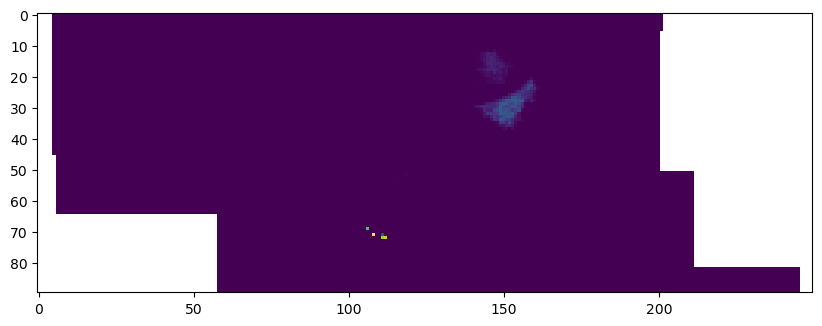

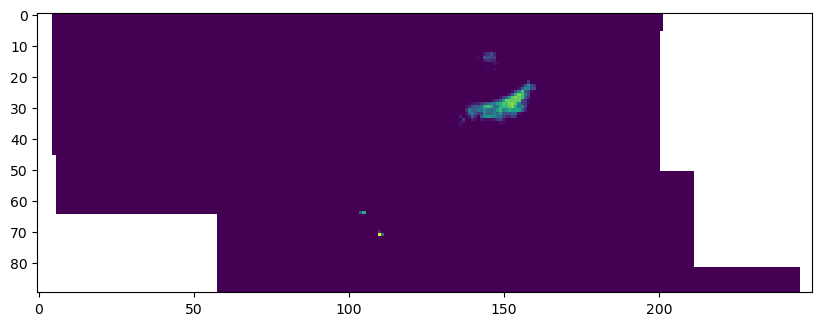

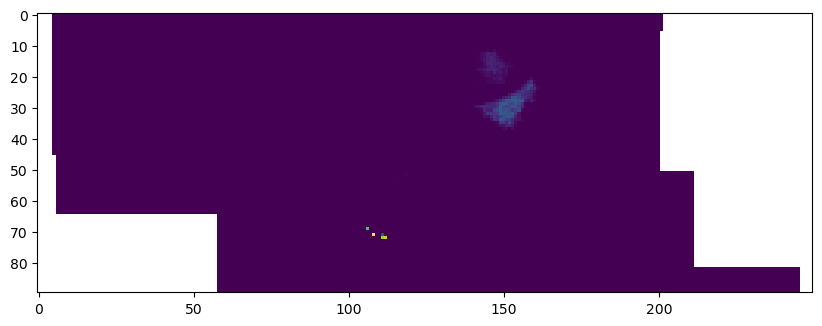

In [5]:

root_dir = r'..\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001000000.tif'
root_dir2 = r'..\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001010000.tif'
root_dir3 = r'..\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001020000.tif'
img = rasterio.open(root_dir)
data = img.read(1)  # Read the only band
plt.figure(figsize=(10, 10))
plt.imshow(data)
img2 = rasterio.open(root_dir2)
data2 = img2.read(1)  # Read the only band
plt.figure(figsize=(10, 10))
plt.imshow(data2)
img3 = rasterio.open(root_dir3)
data3 = img.read(1)  # Read the only band
plt.figure(figsize=(10, 10))
plt.imshow(data3)

In [6]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

def hook(module, input, output):
    if torch.isnan(output).any():
        print(f"NaNs in {module}")

def clean_data(data):
    data[np.isinf(data)] = np.finfo(np.float32).max
    data[np.isnan(data)] = 0
    return data

def inspect_raw_data(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1).astype(np.float32)
        has_nans = np.isnan(data).any()
        has_infs = np.isinf(data).any()
        print(f"File: {file_path} - Contains NaNs: {has_nans}, Contains Infs: {has_infs}")


In [7]:
import numpy as np
import torch
from pathlib import Path
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import rasterio
from calendar import monthrange

def print_stats(data, name):
    # Check if data contains any infinite or NaN values and provide statistics
    finite_data = np.isfinite(data)
    if finite_data.all():
        print(f'{name} - Min: {data.min()}, Max: {data.max()}, Mean: {data.mean()}, Std: {data.std()}')
    else:
        finite_only = data[finite_data]  # Filter out non-finite values for stats
        print(f'{name} contains non-finite values: Min: {finite_only.min()}, Max: {finite_only.max()}, Mean: {finite_only.mean()}, Std: {finite_only.std()}')

def clean_data(data):
    """Replace inf and NaN values with the mean of finite values in the array."""
    if not np.isfinite(data).all():
        finite_mean = np.nanmean(data[np.isfinite(data)])  # Mean of finite values
        data = np.nan_to_num(data, nan=finite_mean, posinf=finite_mean, neginf=finite_mean)
    return data

class RadarTIFFDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.transform = transforms.Compose([
            transforms.Lambda(lambda x: clean_data(x)),  # Clean data before any other transformation
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.file_paths) - 2 

    def __getitem__(self, idx):
        with rasterio.open(self.file_paths[idx]) as img1:
            x1 = img1.read(1).astype(np.float32)
            print_stats(x1, "Before transformation X1")
            x1 = self.transform(x1)

        with rasterio.open(self.file_paths[idx + 1]) as img2:
            x2 = img2.read(1).astype(np.float32)
            x2 = self.transform(x2)

        with rasterio.open(self.file_paths[idx + 2]) as img3:
            y = img3.read(1).astype(np.float32)
            y = self.transform(y)

        x = torch.stack([x1, x2], dim=0)
        return x, y

def get_radar_file_paths(year, month, day_range, base_path):
    all_files = []
    base_dir = Path(base_path)
    month_dir = base_dir / str(year) / f"{month:02d}"
    # Adjust day range based on the month and year
    start_day, end_day = day_range.get(year, {}).get(month, (1, monthrange(year, month)[1]))
    for day in range(start_day, end_day + 1):
        day_dir = month_dir / f"{day:02d}"
        if day_dir.exists():  # Check if the directory exists
            tif_files = list(day_dir.glob("*.tif"))
            # Replace backslashes and convert to strings
            tif_files = [str(p).replace("\\", "/") for p in tif_files]
            all_files.extend(tif_files)
    return all_files

# Setup the dictionary for specific day ranges in each month and year
base_path =  r'..\DATA_SV\Precipitation\Radar'
AWS_path =  r'..\DATA_SV\Precipitation\AWS'

train_day_range = {
    2019: {4: (1, 30), 10: (1, 31)},  # All days in April and October 2019
    2020: {4: (1, 15), 10:(0, 0)}  # Days 1 to 15 in April 2020
}

train_years = [2019, 2020]
train_months = [4, 10]

validation_day_range = {
    2020: {4: (16, 30)}  # Days 16 to 30 in April 2020
}
validation_years = [2020]
validation_months = [4]

test_day_range = {
    2020: {10: (30, 31)},  
}
test_years = [2020]
test_months = [10]

train_set = []
validation_set = []
test_set = []
AWS_set = []

for year in train_years:
    for month in train_months:
        train_set.extend(get_radar_file_paths(year, month, train_day_range, base_path))
    
for year in validation_years:
    for month in validation_months:
        validation_set.extend(get_radar_file_paths(year, month, validation_day_range, base_path))

for year in test_years:
    for month in test_months:
        test_set.extend(get_radar_file_paths(year, month, test_day_range, base_path))

for year in test_years:
    for month in test_months:
        AWS_set.extend(get_radar_file_paths(year, month, test_day_range, AWS_path))

# print(all_file_paths)
print(AWS_set)

train_dataset = RadarTIFFDataset(train_set)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

validation_dataset = RadarTIFFDataset(validation_set)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

test_dataset = RadarTIFFDataset(test_set)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

AWS_dataset = RadarTIFFDataset(AWS_set)
AWS_loader = DataLoader(AWS_dataset, batch_size=1, shuffle=False)
# for x, y in dataloader:
#     print("Input shape:", x.shape)  
#     print("Output shape:", y.shape) 


['../DATA_SV/Precipitation/AWS/2020/10/30/AWS_20201030000000.tif', '../DATA_SV/Precipitation/AWS/2020/10/30/AWS_20201030010000.tif', '../DATA_SV/Precipitation/AWS/2020/10/30/AWS_20201030020000.tif', '../DATA_SV/Precipitation/AWS/2020/10/30/AWS_20201030030000.tif', '../DATA_SV/Precipitation/AWS/2020/10/30/AWS_20201030040000.tif', '../DATA_SV/Precipitation/AWS/2020/10/30/AWS_20201030050000.tif', '../DATA_SV/Precipitation/AWS/2020/10/30/AWS_20201030060000.tif', '../DATA_SV/Precipitation/AWS/2020/10/30/AWS_20201030070000.tif', '../DATA_SV/Precipitation/AWS/2020/10/30/AWS_20201030080000.tif', '../DATA_SV/Precipitation/AWS/2020/10/30/AWS_20201030090000.tif', '../DATA_SV/Precipitation/AWS/2020/10/30/AWS_20201030100000.tif', '../DATA_SV/Precipitation/AWS/2020/10/30/AWS_20201030110000.tif', '../DATA_SV/Precipitation/AWS/2020/10/30/AWS_20201030120000.tif', '../DATA_SV/Precipitation/AWS/2020/10/30/AWS_20201030130000.tif', '../DATA_SV/Precipitation/AWS/2020/10/30/AWS_20201030140000.tif', '../DATA_

In [8]:
from torch.optim import Adam
import time

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # Change based on your activation
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # Adjust accordingly
        if m.bias is not None:
            nn.init.zeros_(m.bias)
def check_nan_inf(data, name="Data"):
    if torch.isnan(data).any():
        print(f'{name} contains NaNs')
    if torch.isinf(data).any():
        print(f'{name} contains Infs')

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y_true in dataloader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y_true)
            total_loss += loss.item()
    average_loss = total_loss / len(dataloader)
    return average_loss

save_dir = '../simvp//pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimVP(shape_in=(2, 3, 128, 128)).to(device)
model.apply(init_weights)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
# num_epochs = 1


def train_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, num_epochs, device, save_dir):
    start_epoch = 0
    checkpoint_path = os.path.join(save_dir, 'last_checkpoint.pth')
    
    # Load checkpoint if exists
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Loaded checkpoint from epoch {start_epoch}")
    
    for epoch in range(start_epoch, num_epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0
        for x, y_true in train_loader:
            x, y_true = x.to(device), y_true.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y_true)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_train_loss += loss.item()

        epoch_time = time.time() - start_time
        average_train_loss = total_train_loss / len(train_loader)
        validation_loss = validate(model, validation_loader, criterion, device)
        
        print(f'Epoch {epoch+1}, Train Loss: {average_train_loss:.4f}, Validation Loss: {validation_loss:.4f}')
        
        # Save the model and optimizer state
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
        }
        torch.save(checkpoint, checkpoint_path)
        print(f'Model and optimizer state saved for epoch {epoch+1} at {checkpoint_path}')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimVP(shape_in=(2, 1, 90, 250)).to(device)
model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

# train_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, num_epochs=30, device=device, save_dir = '../simvp//pth')

In [9]:
# Load the checkpoint
checkpoint = torch.load('D:\\Workspace\\Projects\\qpn-simvp\\simvp\\pth\\last_checkpoint.pth')
print(checkpoint.keys())
# Assume the model's state dictionary is stored under 'model_state_dict'
model.load_state_dict(checkpoint['model_state_dict'])
model_dict = model.state_dict()
# 1. Filter out unnecessary keys
pretrained_dict = {k: v for k, v in checkpoint['model_state_dict'].items() if k in model_dict and model_dict[k].size() == v.size()}
# 2. Overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. Load the new state dict
model.load_state_dict(model_dict)


dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict'])


<All keys matched successfully>

In [10]:
# Helper function to extract date and time from filename
def extract_datetime_from_filename(filename):
    # Extract the timestamp part from the filename
    timestamp_str = filename.split('_')[-1].split('.')[0]
    # Convert to datetime object
    timestamp = datetime.datetime.strptime(timestamp_str, '%Y%m%d%H%M%S')
    return timestamp

# Define function to predict next timestamp
def predict_next_datetime(current_datetime, time_step_minutes=120):
    return current_datetime + datetime.timedelta(minutes=time_step_minutes)

def print_stats(data, name):
    finite_data = np.isfinite(data)
    if finite_data.all():
        print(f'{name} - Min: {data.min()}, Max: {data.max()}, Mean: {data.mean()}, Std: {data.std()}')
    else:
        finite_vals = data[finite_data]
        print(f'{name} contains non-finite values. Finite stats - Min: {finite_vals.min()}, Max: {finite_vals.max()}, Mean: {finite_vals.mean()}, Std: {finite_vals.std()}')

def clean_data(data):
    finite_vals = np.isfinite(data)
    if not finite_vals.all():
        min_val = np.min(data[finite_vals]) if np.any(finite_vals) else 0
        max_val = np.max(data[finite_vals]) if np.any(finite_vals) else 1
        data = np.clip(data, min_val, max_val)
        data[~finite_vals] = np.mean(data[finite_vals])  # Replace non-finite values with the mean of finite ones
    return data

def extract_datetime_from_filename(file_path):
    filename = file_path.split('\\')[-1]
    datetime_str = filename.split('_')[1].split('.')[0]
    return datetime.strptime(datetime_str, "%Y%m%d%H%M%S")

def predict_next_datetime(current_datetime):
    return current_datetime + timedelta(hours=1)

def compute_metrics(prediction, ground_truth):
    mse = np.mean((prediction - ground_truth) ** 2)
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    ssim_index = ssim(prediction, ground_truth, data_range=ground_truth.max() - ground_truth.min())
    return mse, psnr, ssim_index

torch.Size([1, 2, 1, 90, 250])
Non-finite values detected in predictions.
Prediction is clean.


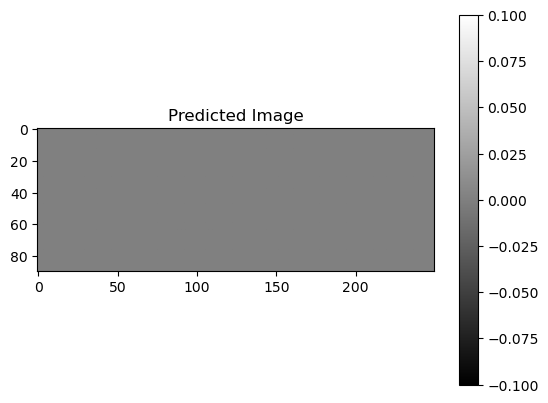

Current datetime from input file: 2020-10-01 00:00:00
Predicted datetime for next frame: 2020-10-01 01:00:00


In [11]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import rasterio

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_file_path = 'D:\\Workspace\\Projects\\qpn-simvp\\DATA_SV\\Precipitation\\Radar\\2020\\10\\01\\Radar_20201001000000.tif'

with rasterio.open(input_file_path) as src:
    input_data = src.read(1)

input_data = input_data.astype(np.float32)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply transformation
input_tensor = transform(input_data)
input_tensor = torch.stack([input_tensor, input_tensor], dim=0) 
input_tensor = input_tensor.unsqueeze(0).to(device) 

# Load the model
model = SimVP(shape_in=(2, 1, 90, 250)).to(device)
checkpoint_path = 'D:\\Workspace\\Projects\\qpn-simvp\\simvp\\pth\\last_checkpoint.pth'
checkpoint = torch.load(checkpoint_path)

if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)  

model.eval()

# Predict and visualize
with torch.no_grad():
    prediction = model(input_tensor)

# Checking for non-finite values in predictions
finite_mask = torch.isfinite(prediction)
if not finite_mask.all():
    print("Non-finite values detected in predictions.")
    prediction[~finite_mask] = 0  # Replace non-finite values with zero or some appropriate value

predicted_image = prediction.squeeze().cpu().numpy()
if np.isfinite(predicted_image).all():
    print("Prediction is clean.")
    plt.imshow(predicted_image[0], cmap='gray')  
    plt.colorbar()
    plt.title("Predicted Image")
    plt.show()
else:
    print("Still contains non-finite values after correction.")

def extract_datetime_from_filename(file_path: str) -> datetime.datetime:
    filename = file_path.split('\\')[-1]
    datetime_str = filename.split('_')[1].split('.')[0]
    return datetime.datetime.strptime(datetime_str, "%Y%m%d%H%M%S")

def predict_next_datetime(current_datetime: datetime.datetime) -> datetime.datetime:
    return current_datetime + datetime.timedelta(hours=1)

current_datetime = extract_datetime_from_filename(input_file_path)
print("Current datetime from input file:", current_datetime)

predicted_datetime = predict_next_datetime(current_datetime)
print("Predicted datetime for next frame:", predicted_datetime)


Input Data contains non-finite values: Min: 0.0, Max: 35.6875, Mean: 0.473196804523468, Std: 1.6914092302322388
torch.Size([1, 2, 1, 90, 250])
Actual Data contains non-finite values: Min: 0.0, Max: 7.800000190734863, Mean: 0.5355633497238159, Std: 1.2206422090530396
Actual Data2 contains non-finite values: Min: 0.0, Max: 27.6875, Mean: 0.37458086013793945, Std: 1.2459444999694824
Precision: 0.9928, CSI: 0.0372, RMSE: 0.7750


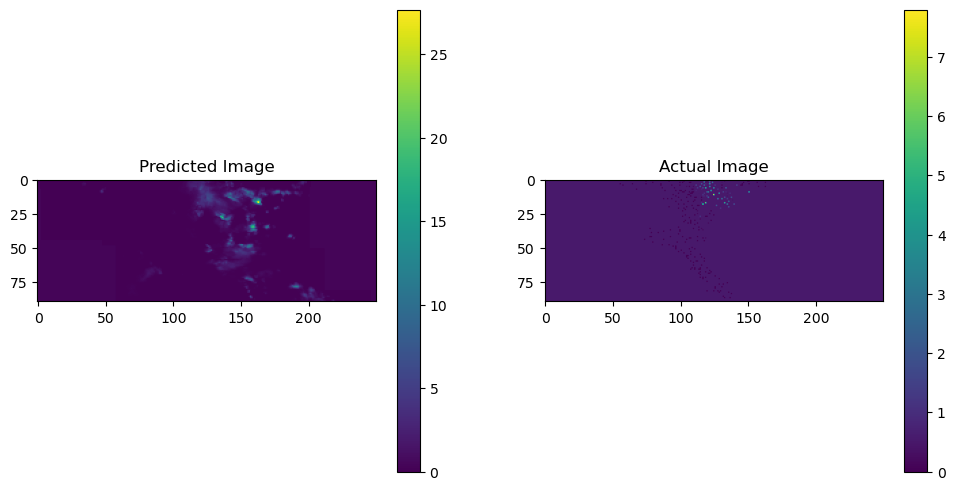

In [16]:
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import rasterio
from sklearn.metrics import confusion_matrix

def print_stats(data, name):
    finite_data = np.isfinite(data)
    if finite_data.all():
        print(f'{name} - Min: {data.min()}, Max: {data.max()}, Mean: {data.mean()}, Std: {data.std()}')
    else:
        finite_only = data[finite_data]  # Only use finite values for stats
        print(f'{name} contains non-finite values: Min: {finite_only.min()}, Max: {finite_only.max()}, Mean: {finite_only.mean()}, Std: {finite_only.std()}')

def clean_data(data):
    """Cleans data by setting non-finite values to the mean of finite values."""
    finite_mean = np.nanmean(data[np.isfinite(data)]) if np.isfinite(data).any() else 0
    return np.nan_to_num(data, nan=finite_mean, posinf=finite_mean, neginf=finite_mean)

def compute_metrics(prediction, ground_truth, threshold=0.1):
    pred_flat = prediction.flatten()
    gt_flat = ground_truth.flatten()
    pred_binary = (pred_flat >= threshold).astype(int)
    gt_binary = (gt_flat >= threshold).astype(int)
    cm = confusion_matrix(gt_binary, pred_binary).ravel()
    tn, fp, fn, tp = (cm if len(cm) == 4 else [0, 0, 0, 0] + cm.tolist())[:4]
    precision = tp / (tp + fp) if (tp + fp) else 0
    csi = tp / (tp + fp + fn) if (tp + fp + fn) else 0
    rmse = np.sqrt(np.mean((pred_flat - gt_flat) ** 2))
    return precision, csi, rmse

# Configuration and data loading
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_file_path = 'D:\\Workspace\\Projects\\qpn-simvp\\DATA_SV\\Precipitation\\Radar\\2020\\10\\01\\Radar_20201001000000.tif'
with rasterio.open(input_file_path) as src:
    input_data = src.read(1).astype(np.float32)
    print_stats(input_data, "Input Data")
    input_data = clean_data(input_data)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
input_tensor = transform(input_data)
input_tensor = torch.stack([input_tensor, input_tensor], dim=0)
input_tensor = input_tensor.unsqueeze(0).to(device)

# Model loading and prediction
model = SimVP(shape_in=(2, 1, 90, 250)).to(device)
model.eval()
with torch.no_grad():
    prediction = model(input_tensor)
predicted_image = prediction.squeeze().cpu().numpy()

# Metric computation and result display within try-except block
try:
    actual_file_path = 'D:\\Workspace\\Projects\\qpn-simvp\\DATA_SV\\Precipitation\\AWS\\2020\\10\\01\\AWS_20201001010000.tif'
    actual_file_path2 = 'D:\\Workspace\\Projects\\qpn-simvp\\DATA_SV\\Precipitation\\Radar\\2020\\10\\01\\Radar_20201001010000.tif'
    with rasterio.open(actual_file_path) as src:
        actual_data = src.read(1).astype(np.float32)
        print_stats(actual_data, "Actual Data")
        actual_data = clean_data(actual_data)
    with rasterio.open(actual_file_path2) as src:
        actual_data2 = src.read(1).astype(np.float32)
        print_stats(actual_data2, "Actual Data2")
        actual_data2 = clean_data(actual_data2)
    precision, csi, rmse = compute_metrics(predicted_image[0], actual_data)
    print(f'Precision: {precision:.4f}, CSI: {csi:.4f}, RMSE: {rmse:.4f}')
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(actual_data2, cmap='viridis')
    plt.colorbar()
    plt.title("Predicted Image")
    plt.subplot(1, 2, 2)
    plt.imshow(actual_data, cmap='viridis')
    plt.colorbar()
    plt.title("Actual Image")
    plt.show()
except FileNotFoundError:
    print(f"Actual next image file not found: {actual_file_path}")


Precision: 0.9894, CSI: 0.7615, RMSE: 0.6872


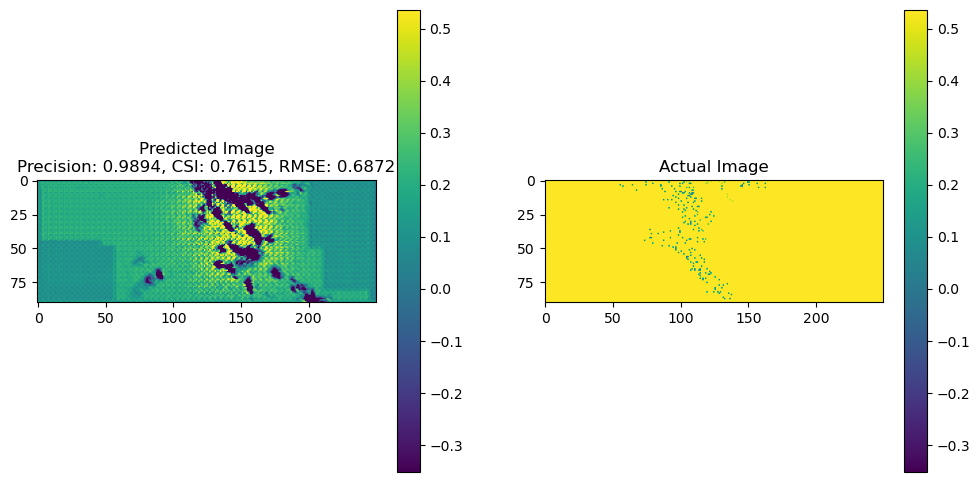

In [13]:
import numpy as np
from sklearn.metrics import precision_score, confusion_matrix

def compute_metrics(prediction, ground_truth, threshold=0.1):
    # Flatten the arrays to compute metrics
    pred_flat = prediction.flatten()
    gt_flat = ground_truth.flatten()
    
    # Binarize predictions and ground truth based on threshold
    pred_binary = (pred_flat >= threshold).astype(int)
    gt_binary = (gt_flat >= threshold).astype(int)
    
    # Compute confusion matrix
    cm = confusion_matrix(gt_binary, pred_binary)
    if cm.shape == (2, 2):  # Ensure the confusion matrix is complete
        tn, fp, fn, tp = cm.ravel()
    else:
        # Handle cases where true negatives or positives might be missing
        tn, fp, fn, tp = 0, 0, 0, 0
        if cm.shape == (1, 1):
            if pred_binary[0] == 0 and gt_binary[0] == 0:
                tn = cm[0, 0]
            else:
                tp = cm[0, 0]
    
    # Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Critical Success Index (CSI)
    csi = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    
    # Root Mean Square Error (RMSE)
    rmse = np.sqrt(np.mean((pred_flat - gt_flat) ** 2))
    
    return precision, csi, rmse

precision, csi, rmse = compute_metrics(predicted_image[0], actual_data)

print(f'Precision: {precision:.4f}, CSI: {csi:.4f}, RMSE: {rmse:.4f}')

def get_vmin_vmax(image, lower_pct=5, upper_pct=95):
    return np.percentile(image, lower_pct), np.percentile(image, upper_pct)

predicted_vmin, predicted_vmax = get_vmin_vmax(predicted_image[0])
actual_vmin, actual_vmax = get_vmin_vmax(actual_data)

plt.figure(figsize=(12, 6))

vmin = predicted_vmin if predicted_vmin < actual_vmin else actual_vmin
vmax = predicted_vmax if predicted_vmax > actual_vmax else actual_vmax
# Adjusting subplot for predicted image
plt.subplot(1, 2, 1)
plt.imshow(predicted_image[0], cmap='viridis', vmin=vmin, vmax=vmax)  
# plt.imshow(predicted_image[0], cmap='viridis', vmin=actual_vmin, vmax=actual_vmax)  
# plt.imshow(predicted_image[0], cmap='viridis', vmin=predicted_vmin, vmax=predicted_vmax)  
plt.colorbar()
plt.title(f"Predicted Image\nPrecision: {precision:.4f}, CSI: {csi:.4f}, RMSE: {rmse:.4f}")

# Adjusting subplot for actual image
plt.subplot(1, 2, 2)
plt.imshow(actual_data, cmap='viridis', vmin=vmin, vmax=vmax)
# plt.imshow(actual_data, cmap='viridis', vmin=actual_vmin, vmax=actual_vmax)
plt.colorbar()
plt.title("Actual Image")

plt.show()

Before transformation X1 contains non-finite values: Min: 0.0, Max: 86.0625, Mean: 0.8693590760231018, Std: 4.287816047668457
Before transformation X1 contains non-finite values: Min: 0.0, Max: 90.19999694824219, Mean: 3.458833932876587, Std: 11.01204776763916
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9831, CSI: 0.0143, RMSE: 6.2863


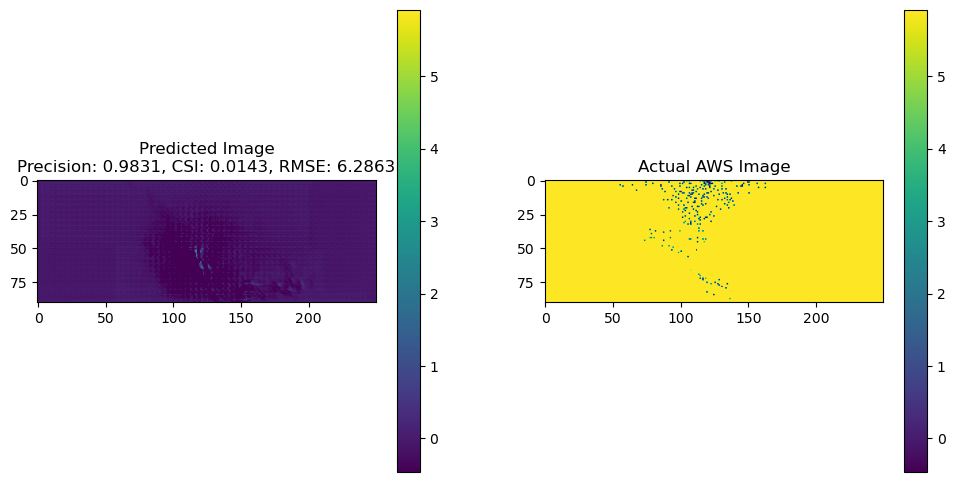

Before transformation X1 contains non-finite values: Min: 0.0, Max: 81.328125, Mean: 0.8309062719345093, Std: 3.9669666290283203
Before transformation X1 contains non-finite values: Min: 0.0, Max: 86.80000305175781, Mean: 3.1602699756622314, Std: 9.773138046264648
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9846, CSI: 0.0129, RMSE: 6.1821


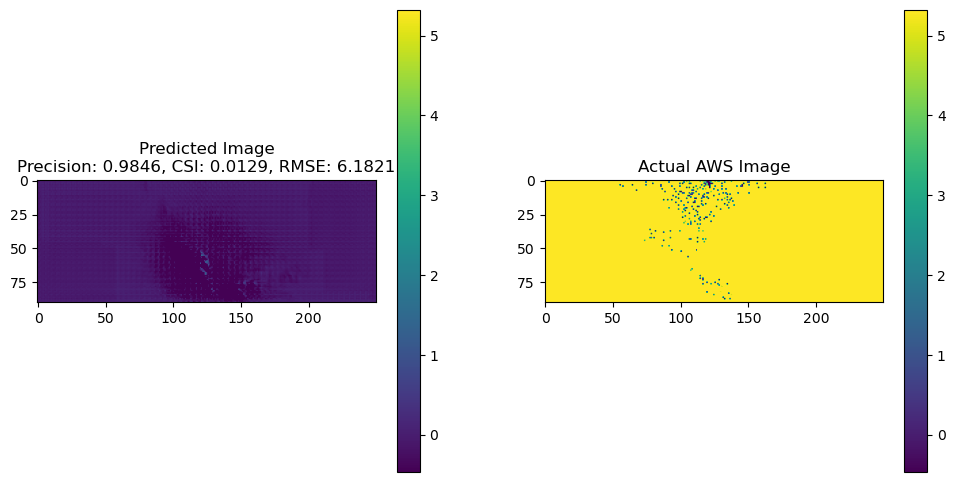

Before transformation X1 contains non-finite values: Min: 0.0, Max: 91.4375, Mean: 0.9581546783447266, Std: 4.735373020172119
Before transformation X1 contains non-finite values: Min: 0.0, Max: 83.19999694824219, Mean: 3.4094908237457275, Std: 9.581221580505371
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9844, CSI: 0.0099, RMSE: 6.3714


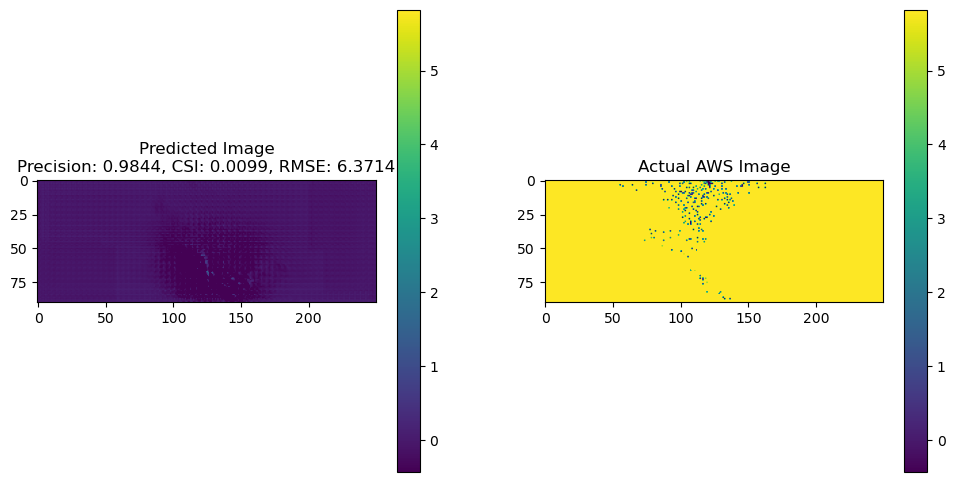

Before transformation X1 contains non-finite values: Min: 0.0, Max: 220.125, Mean: 1.3880335092544556, Std: 8.789605140686035
Before transformation X1 contains non-finite values: Min: 0.0, Max: 67.4000015258789, Mean: 3.383802652359009, Std: 9.379151344299316
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9787, CSI: 0.0062, RMSE: 6.8248


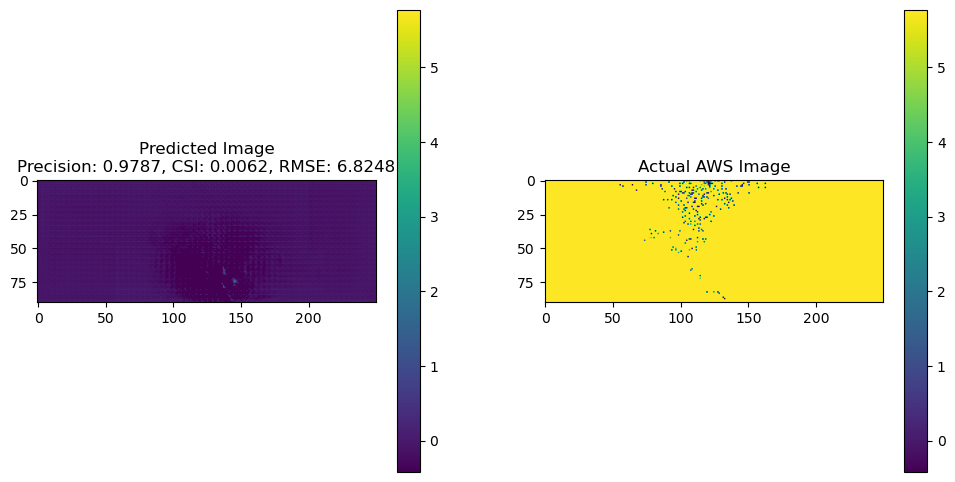

Before transformation X1 contains non-finite values: Min: 0.0, Max: 147.21875, Mean: 1.1042486429214478, Std: 6.4888129234313965
Before transformation X1 contains non-finite values: Min: 0.0, Max: 68.0, Mean: 3.8344485759735107, Std: 10.525455474853516
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9707, CSI: 0.0074, RMSE: 6.3227


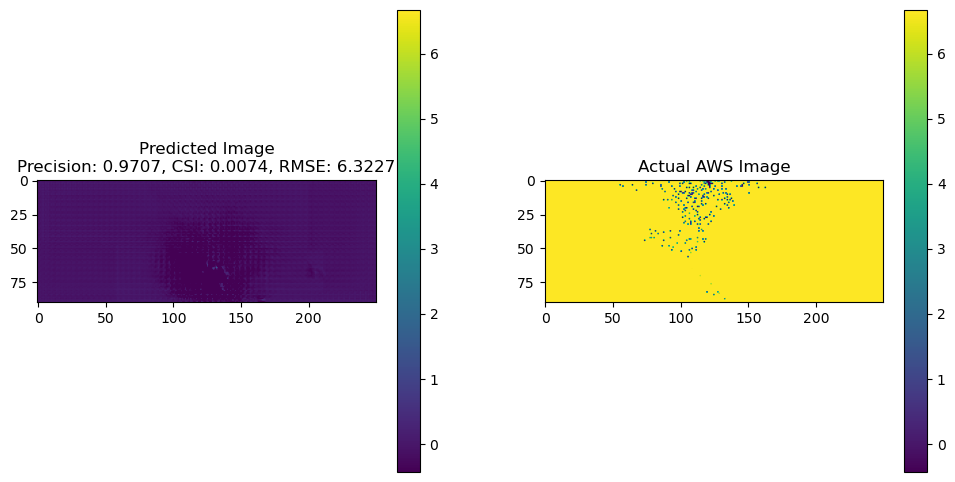

Before transformation X1 contains non-finite values: Min: 0.0, Max: 119.5, Mean: 0.9178175926208496, Std: 5.345936298370361
Before transformation X1 contains non-finite values: Min: 0.0, Max: 47.0, Mean: 2.8716201782226562, Std: 7.148252964019775
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9833, CSI: 0.0106, RMSE: 4.6874


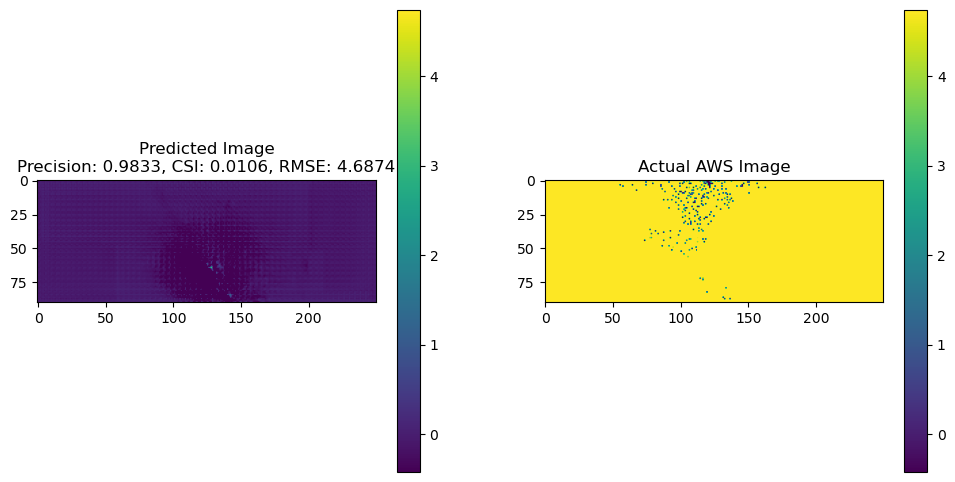

Before transformation X1 contains non-finite values: Min: 0.0, Max: 68.0, Mean: 0.4803362190723419, Std: 2.3398122787475586
Before transformation X1 contains non-finite values: Min: 0.0, Max: 37.0, Mean: 2.3480186462402344, Std: 5.514141082763672
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9793, CSI: 0.0201, RMSE: 3.3948


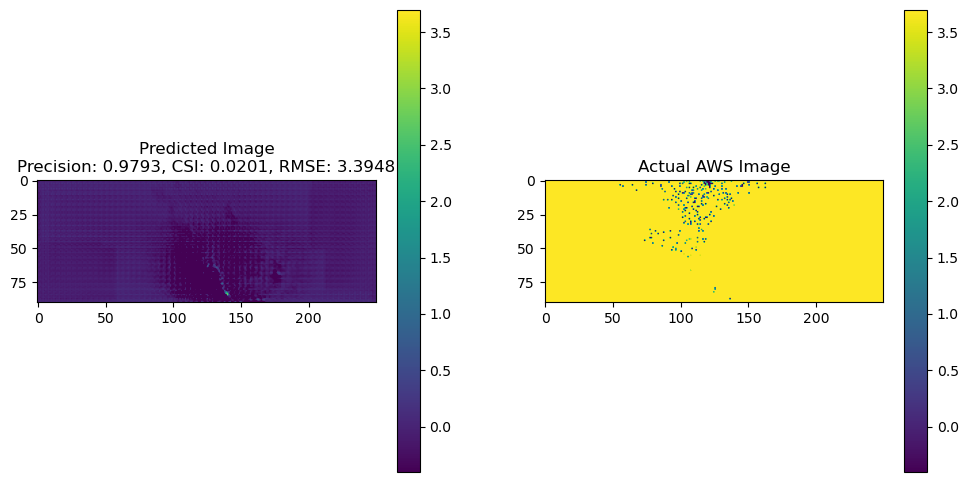

Before transformation X1 contains non-finite values: Min: 0.0, Max: 53.9375, Mean: 0.4259968400001526, Std: 2.1887497901916504
Before transformation X1 contains non-finite values: Min: 0.0, Max: 28.899999618530273, Mean: 1.5689234733581543, Std: 3.8940680027008057
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9781, CSI: 0.0200, RMSE: 2.1176


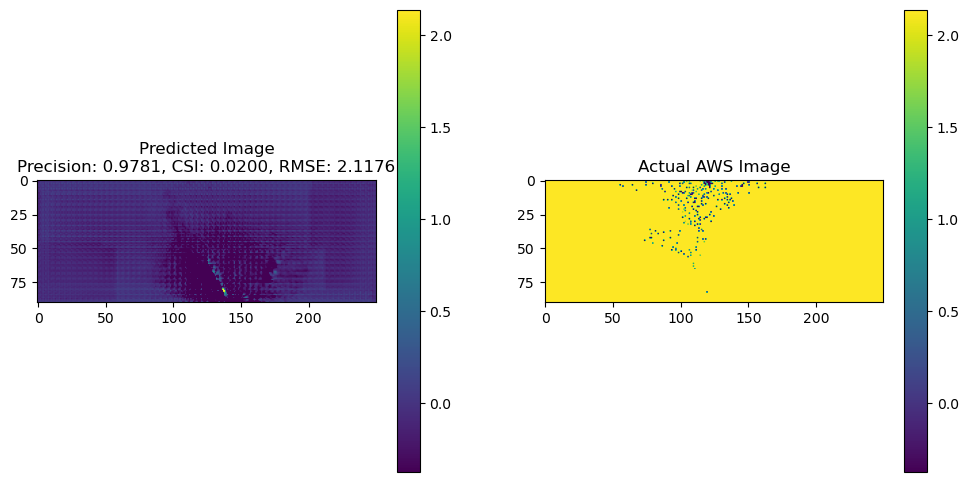

Before transformation X1 contains non-finite values: Min: 0.0, Max: 73.4375, Mean: 0.29317763447761536, Std: 2.034883975982666
Before transformation X1 contains non-finite values: Min: 0.0, Max: 63.20000076293945, Mean: 1.0257208347320557, Std: 4.5343403816223145
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9718, CSI: 0.0201, RMSE: 1.2641


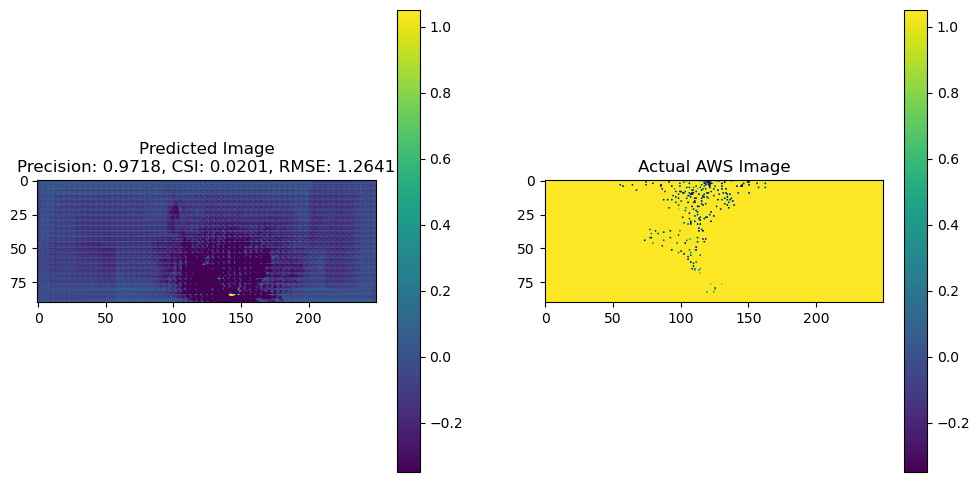

Before transformation X1 contains non-finite values: Min: 0.0, Max: 47.4375, Mean: 0.2622844874858856, Std: 1.843373417854309
Before transformation X1 contains non-finite values: Min: 0.0, Max: 19.0, Mean: 0.6460261344909668, Std: 2.0772299766540527
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9738, CSI: 0.0217, RMSE: 0.8216


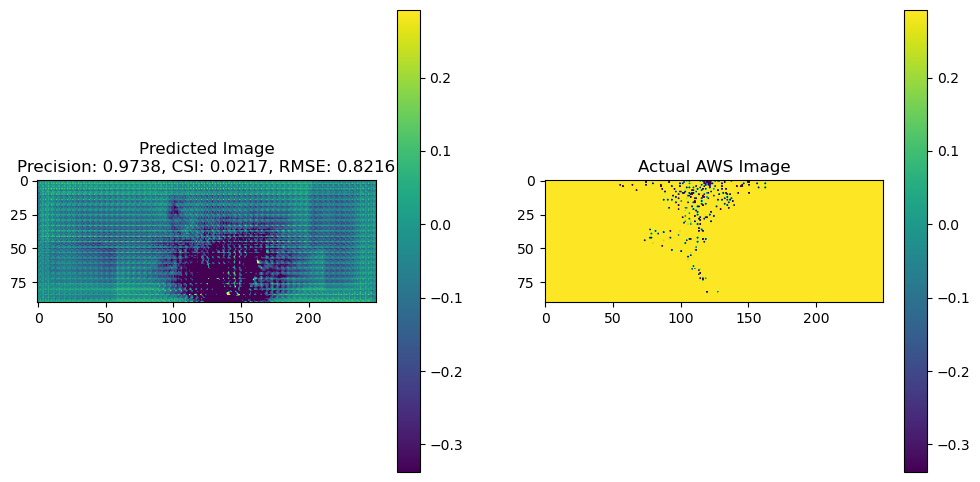

Before transformation X1 contains non-finite values: Min: 0.0, Max: 50.5625, Mean: 0.266117125749588, Std: 1.8999602794647217
Before transformation X1 contains non-finite values: Min: 0.0, Max: 20.0, Mean: 0.7493055462837219, Std: 2.164806842803955
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9791, CSI: 0.0220, RMSE: 0.9926


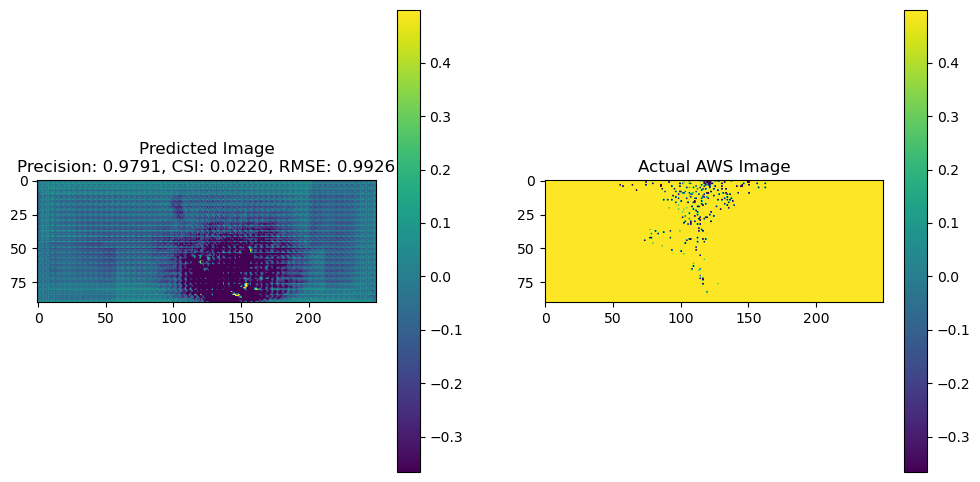

Before transformation X1 contains non-finite values: Min: 0.0, Max: 41.1875, Mean: 0.3359566926956177, Std: 1.862466812133789
Before transformation X1 contains non-finite values: Min: 0.0, Max: 18.200000762939453, Mean: 0.8739257454872131, Std: 2.0107104778289795
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9748, CSI: 0.0208, RMSE: 1.1406


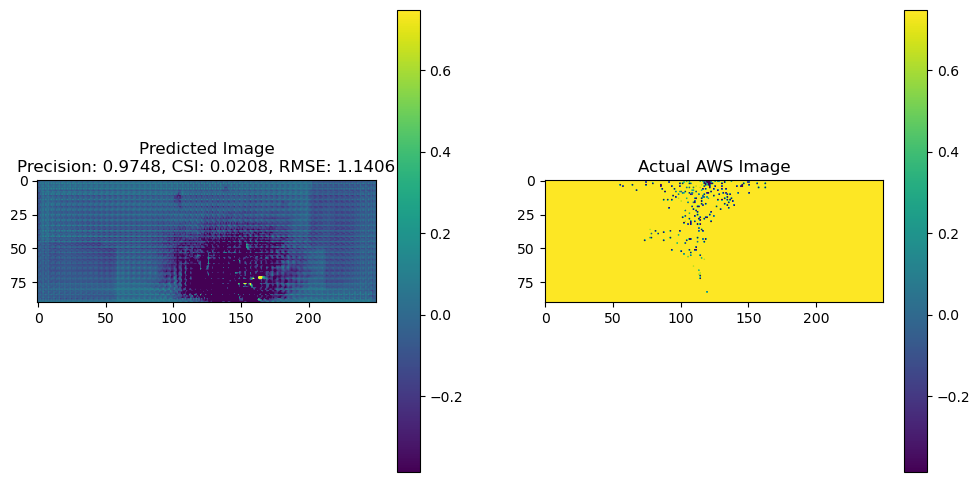

Before transformation X1 contains non-finite values: Min: 0.0, Max: 57.5, Mean: 0.5108745098114014, Std: 3.040224552154541
Before transformation X1 contains non-finite values: Min: 0.0, Max: 20.0, Mean: 0.9372240900993347, Std: 2.030055046081543
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9829, CSI: 0.0129, RMSE: 1.2421


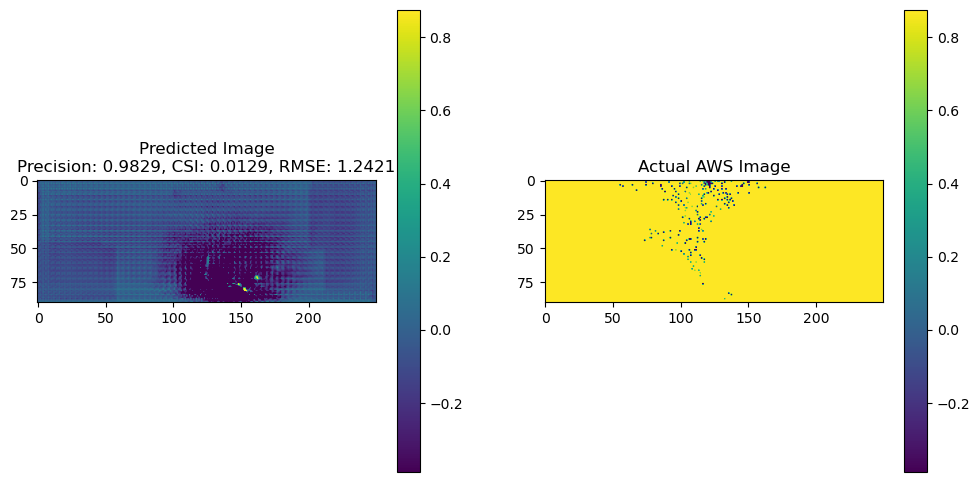

Before transformation X1 contains non-finite values: Min: 0.0, Max: 129.4375, Mean: 0.6604368686676025, Std: 4.7541704177856445
Before transformation X1 contains non-finite values: Min: 0.0, Max: 20.799999237060547, Mean: 0.9576389789581299, Std: 2.4351649284362793
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9825, CSI: 0.0088, RMSE: 1.5268


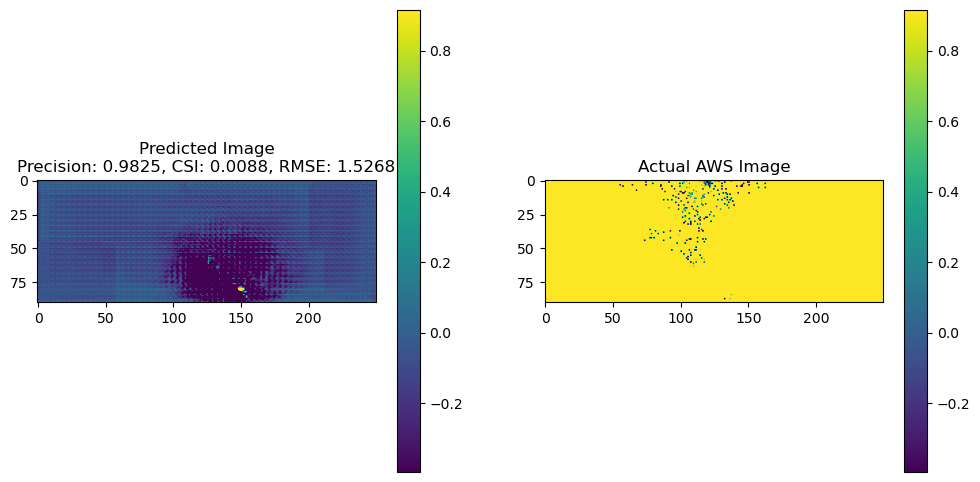

Before transformation X1 contains non-finite values: Min: 0.0, Max: 141.9375, Mean: 0.6700347661972046, Std: 5.337069034576416
Before transformation X1 contains non-finite values: Min: 0.0, Max: 27.799999237060547, Mean: 1.1629499197006226, Std: 3.3614516258239746
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9773, CSI: 0.0087, RMSE: 1.7929


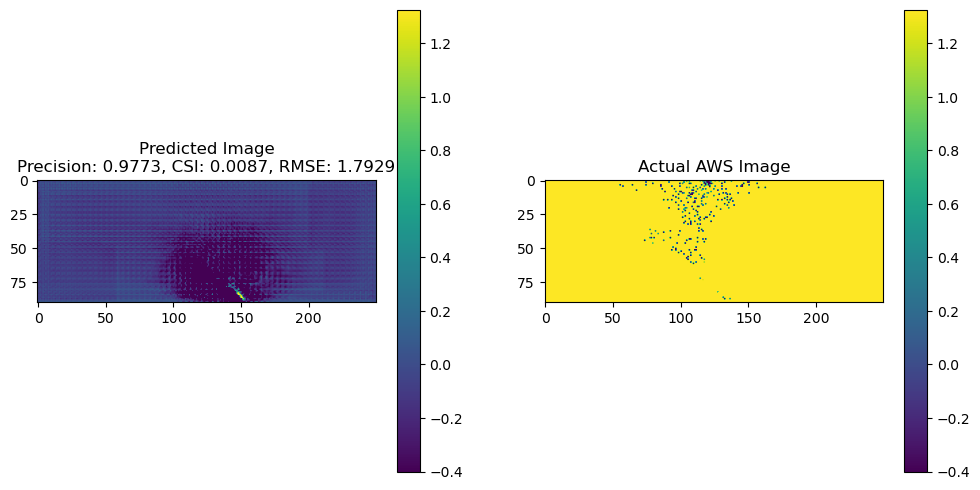

Before transformation X1 contains non-finite values: Min: 0.0, Max: 68.3125, Mean: 0.5297989249229431, Std: 3.37213397026062
Before transformation X1 contains non-finite values: Min: 0.0, Max: 33.599998474121094, Mean: 1.1887354850769043, Std: 3.931298017501831
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9710, CSI: 0.0143, RMSE: 1.7777


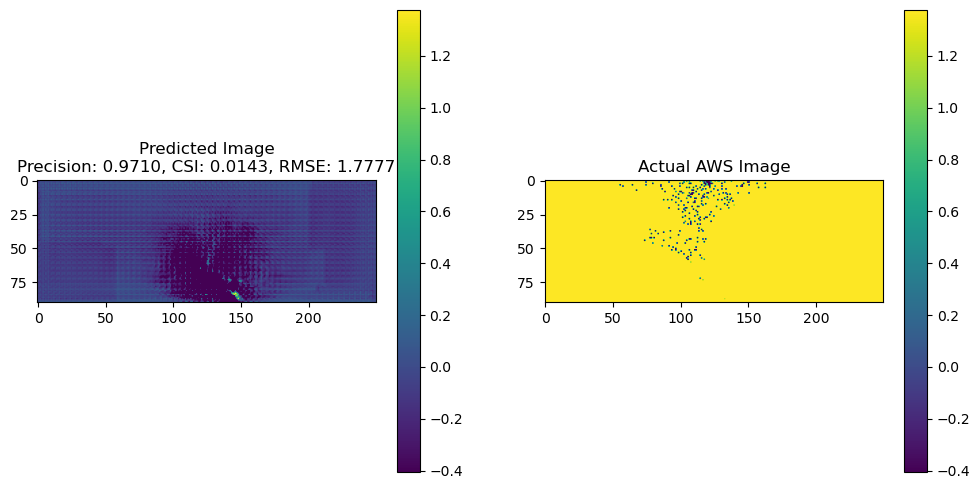

Before transformation X1 contains non-finite values: Min: 0.0, Max: 51.9375, Mean: 0.3578956425189972, Std: 2.227402925491333
Before transformation X1 contains non-finite values: Min: 0.0, Max: 25.0, Mean: 1.1482698917388916, Std: 3.364037036895752
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9780, CSI: 0.0200, RMSE: 1.5350


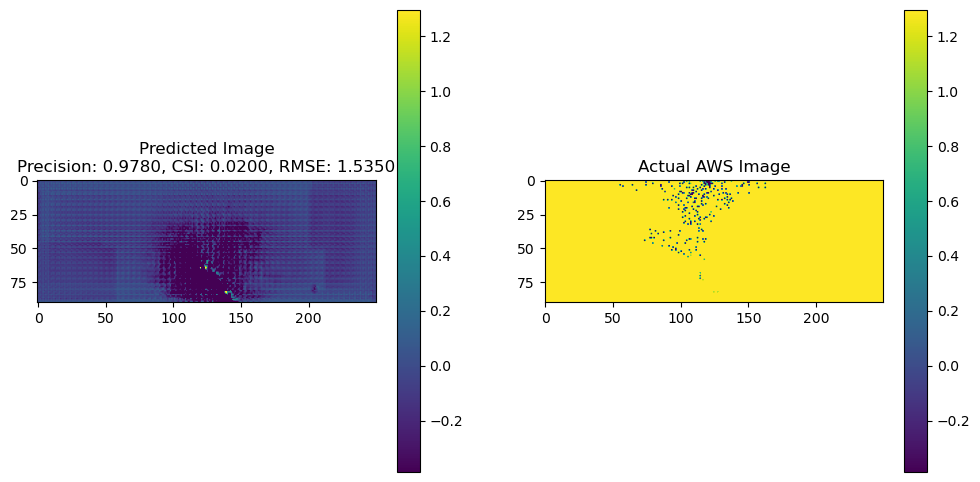

Before transformation X1 contains non-finite values: Min: 0.0, Max: 35.75, Mean: 0.2593456208705902, Std: 1.6289503574371338
Before transformation X1 contains non-finite values: Min: 0.0, Max: 17.600000381469727, Mean: 0.9949476718902588, Std: 2.4948065280914307
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9759, CSI: 0.0255, RMSE: 1.1187


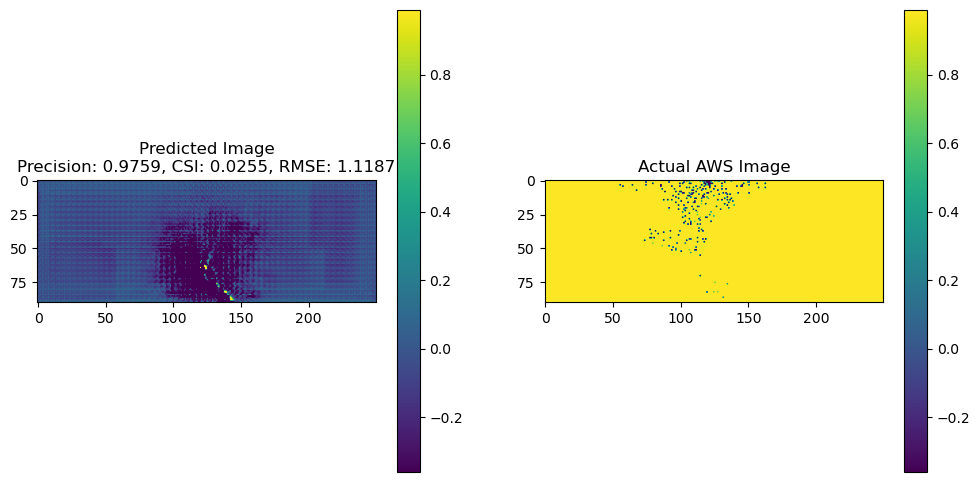

Before transformation X1 contains non-finite values: Min: 0.0, Max: 43.0, Mean: 0.20369914174079895, Std: 1.3427993059158325
Before transformation X1 contains non-finite values: Min: 0.0, Max: 11.399999618530273, Mean: 0.7645179629325867, Std: 1.6311098337173462
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9820, CSI: 0.0317, RMSE: 0.7444


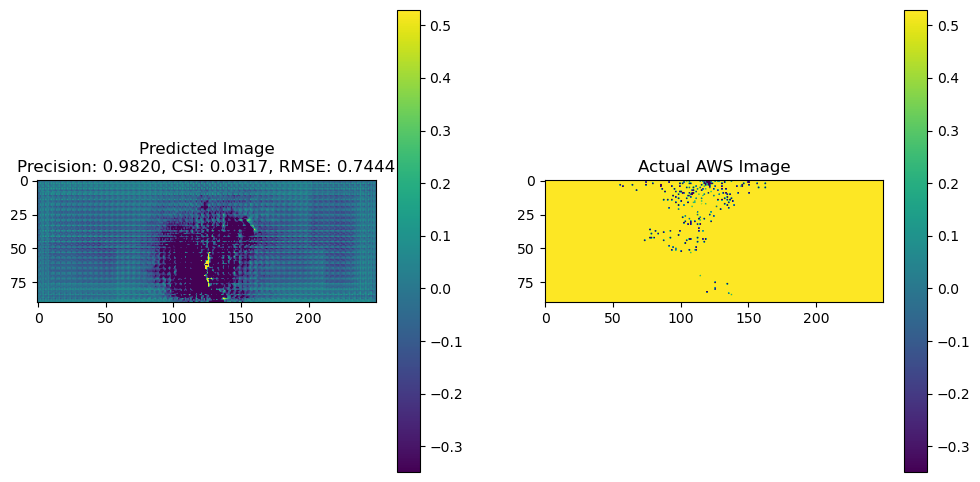

Before transformation X1 contains non-finite values: Min: 0.0, Max: 52.75, Mean: 0.1145060658454895, Std: 1.024666666984558
Before transformation X1 contains non-finite values: Min: 0.0, Max: 10.399999618530273, Mean: 0.642245352268219, Std: 1.36226487159729
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9864, CSI: 0.0423, RMSE: 0.7046


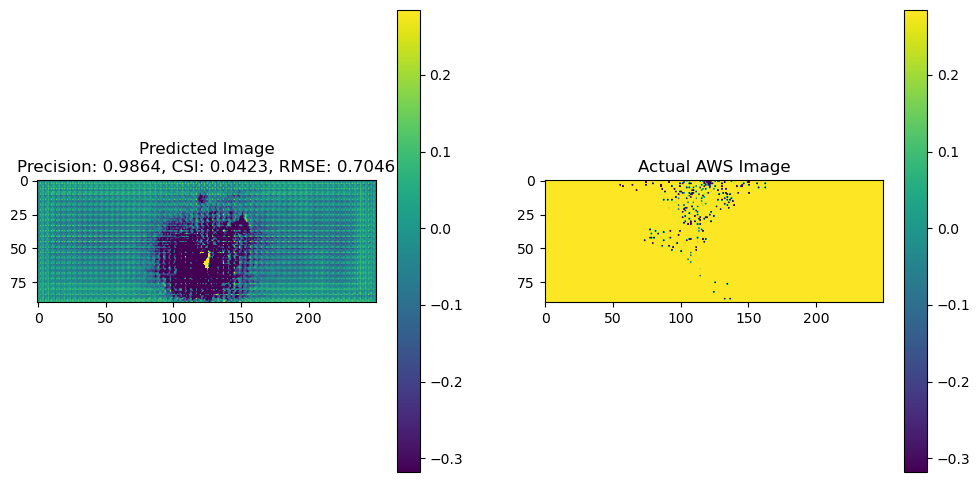

Before transformation X1 contains non-finite values: Min: 0.0, Max: 40.125, Mean: 0.08843868225812912, Std: 0.8748507499694824
Before transformation X1 contains non-finite values: Min: 0.0, Max: 11.800000190734863, Mean: 0.7341924905776978, Std: 1.5196561813354492
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9875, CSI: 0.0462, RMSE: 0.7691


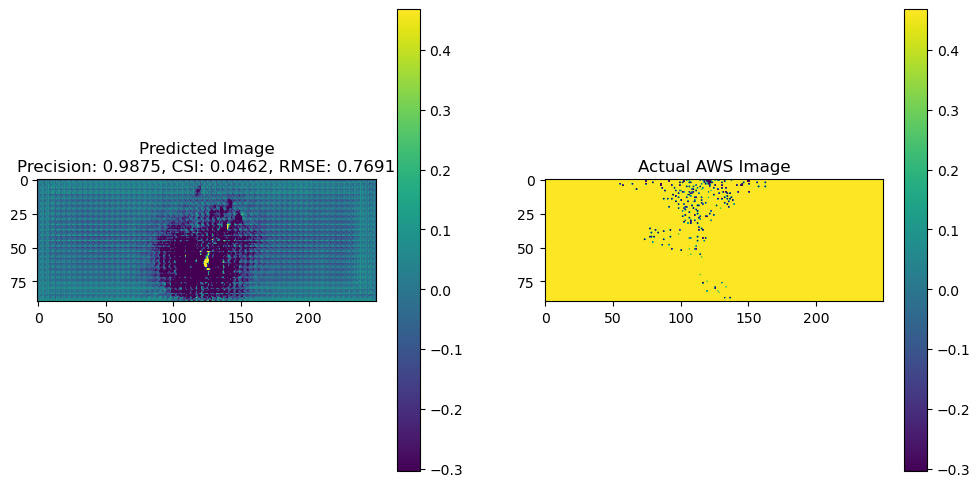

Before transformation X1 contains non-finite values: Min: 0.0, Max: 33.5625, Mean: 0.08170340955257416, Std: 0.9644899964332581
Before transformation X1 contains non-finite values: Min: 0.0, Max: 19.799999237060547, Mean: 0.7136781811714172, Std: 1.7946345806121826
torch.Size([1, 2, 1, 90, 250])
Precision: 0.9840, CSI: 0.0456, RMSE: 0.6792


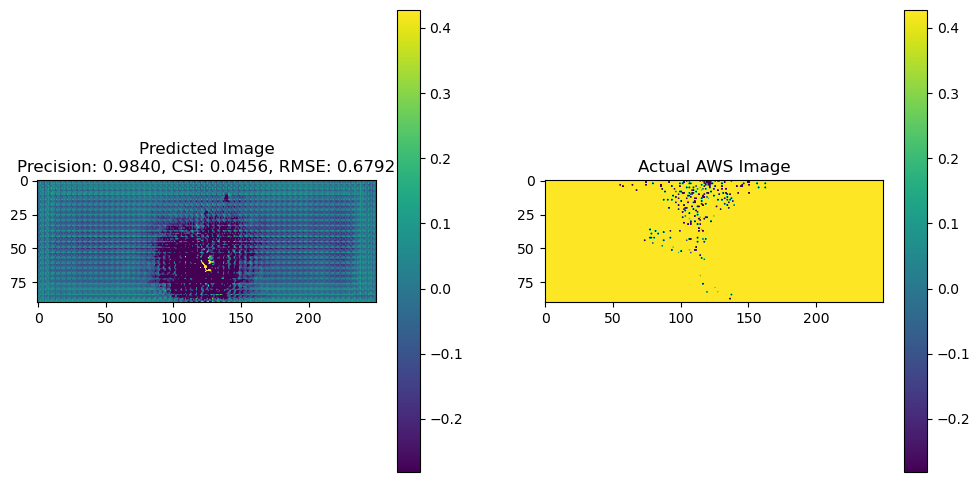

Before transformation X1 contains non-finite values: Min: 0.0, Max: 19.94499969482422, Mean: 0.04122926667332649, Std: 0.42518725991249084
Before transformation X1 contains non-finite values: Min: 0.0, Max: 14.0, Mean: 0.6036458015441895, Std: 1.565977931022644
torch.Size([1, 2, 1, 90, 250])
Precision: 0.6611, CSI: 0.0784, RMSE: 0.4764


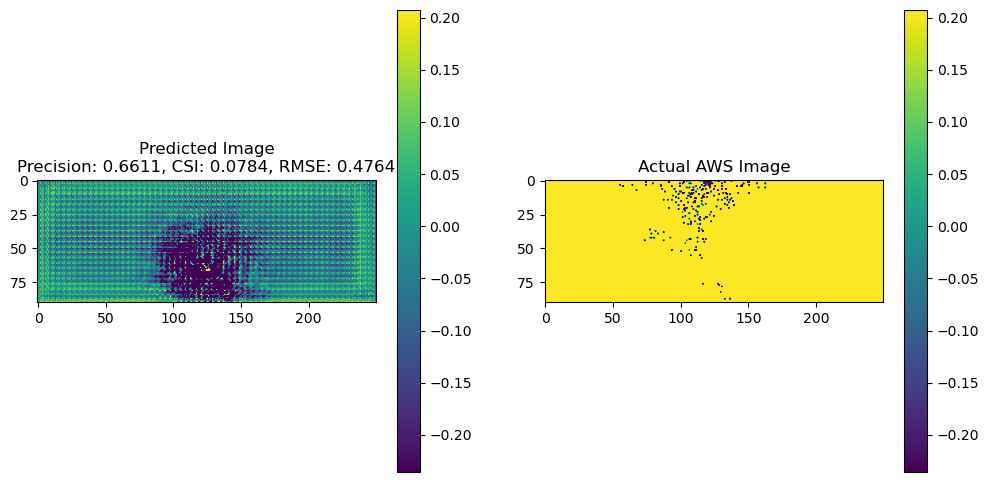

Before transformation X1 contains non-finite values: Min: 0.0, Max: 19.843124389648438, Mean: 0.04847241938114166, Std: 0.45382195711135864
Before transformation X1 contains non-finite values: Min: 0.0, Max: 10.800000190734863, Mean: 0.48493701219558716, Std: 1.192292332649231
torch.Size([1, 2, 1, 90, 250])
Precision: 0.3174, CSI: 0.0357, RMSE: 0.5143


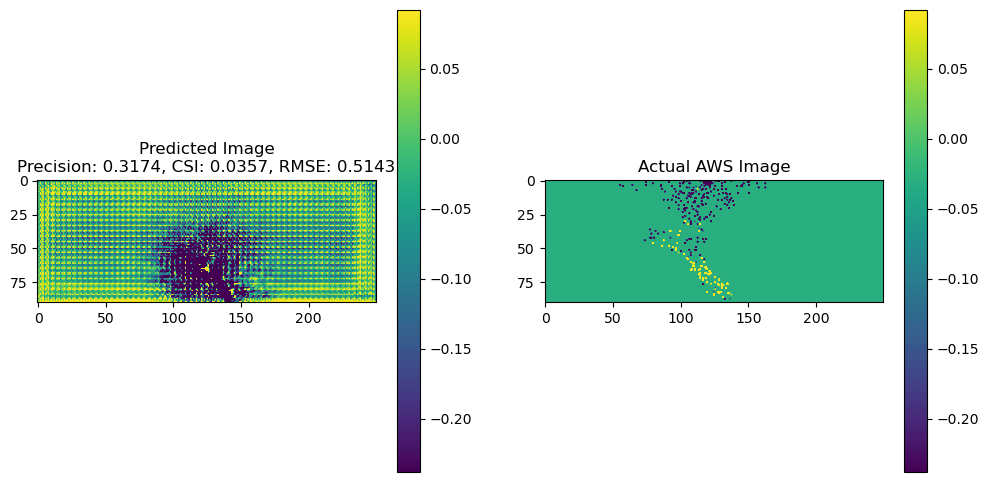

Before transformation X1 contains non-finite values: Min: 0.0, Max: 10.5625, Mean: 0.042438115924596786, Std: 0.388450026512146
Before transformation X1 contains non-finite values: Min: 0.0, Max: 29.0, Mean: 0.5541379451751709, Std: 2.1171224117279053
torch.Size([1, 2, 1, 90, 250])
Precision: 0.6555, CSI: 0.0767, RMSE: 0.5204


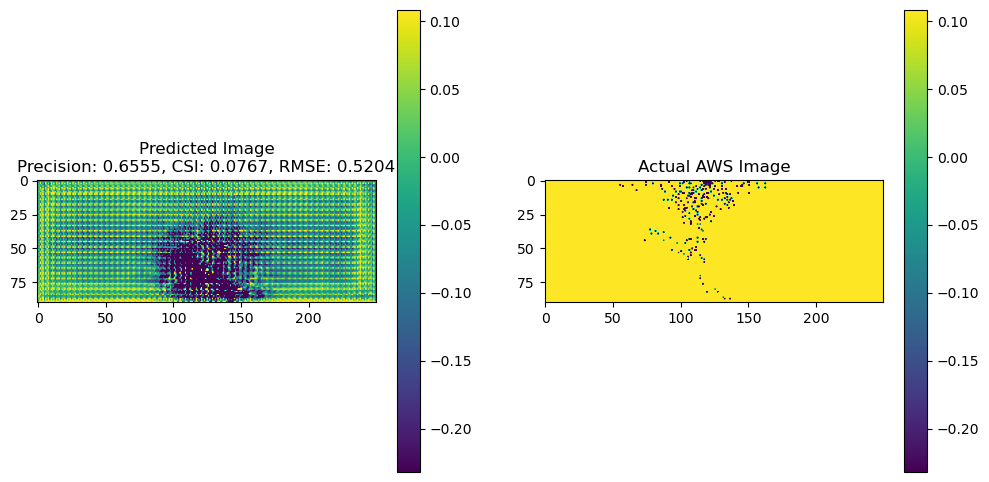

Before transformation X1 contains non-finite values: Min: 0.0, Max: 14.773124694824219, Mean: 0.04937667027115822, Std: 0.4693143367767334
Before transformation X1 contains non-finite values: Min: 0.0, Max: 11.399999618530273, Mean: 0.49452051520347595, Std: 1.3692203760147095
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0015, CSI: 0.0014, RMSE: 0.4310


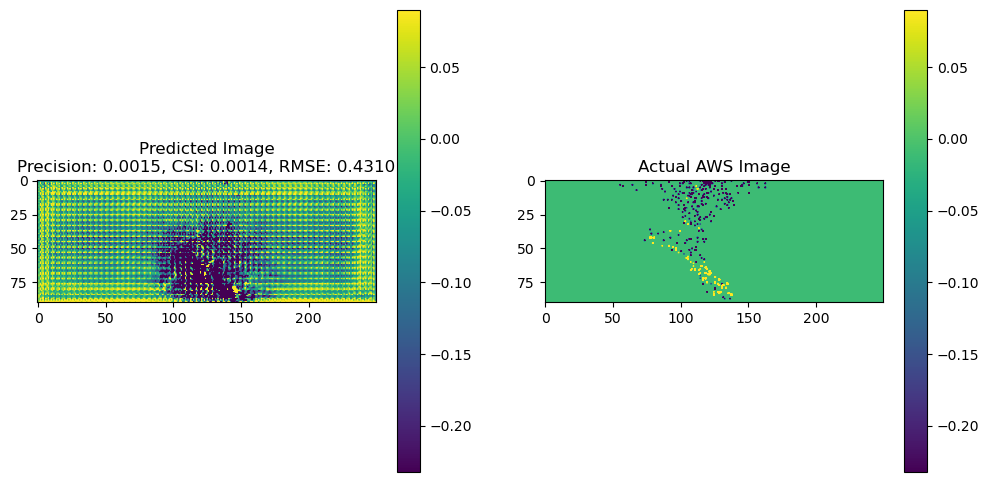

Before transformation X1 contains non-finite values: Min: 0.0, Max: 18.78125, Mean: 0.03716760128736496, Std: 0.4395253658294678
Before transformation X1 contains non-finite values: Min: 0.0, Max: 13.399999618530273, Mean: 0.49032989144325256, Std: 1.367400884628296
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0025, CSI: 0.0024, RMSE: 0.3862


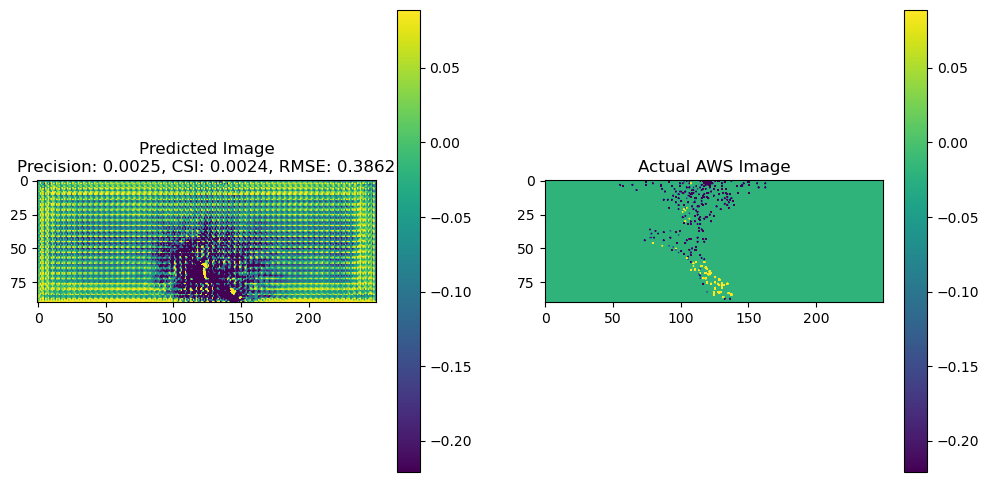

Before transformation X1 contains non-finite values: Min: 0.0, Max: 17.530624389648438, Mean: 0.029497792944312096, Std: 0.430520623922348
Before transformation X1 contains non-finite values: Min: 0.0, Max: 11.600000381469727, Mean: 0.3856164216995239, Std: 1.0479261875152588
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0033, CSI: 0.0032, RMSE: 0.3510


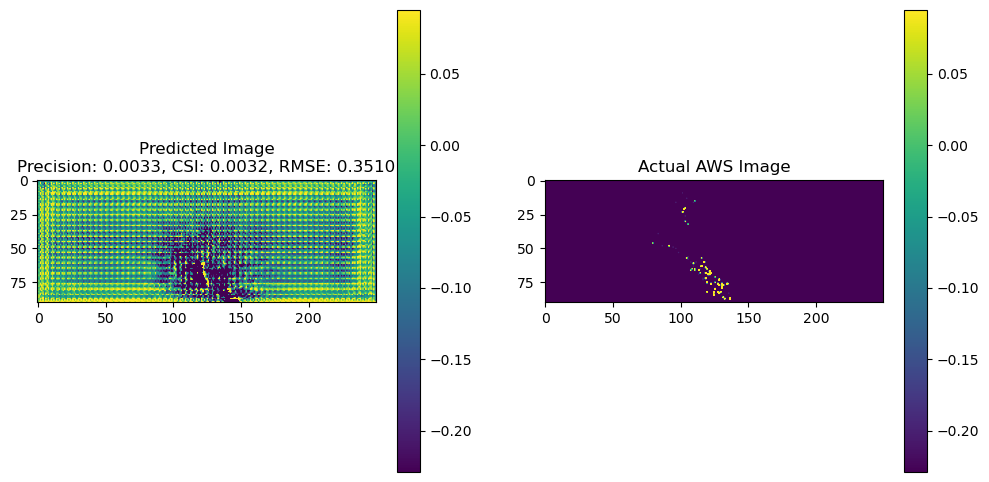

Before transformation X1 contains non-finite values: Min: 0.0, Max: 6.585000038146973, Mean: 0.008507360704243183, Std: 0.15127918124198914
Before transformation X1 contains non-finite values: Min: 0.0, Max: 7.800000190734863, Mean: 0.3299270272254944, Std: 0.9138324856758118
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0013, CSI: 0.0012, RMSE: 0.3902


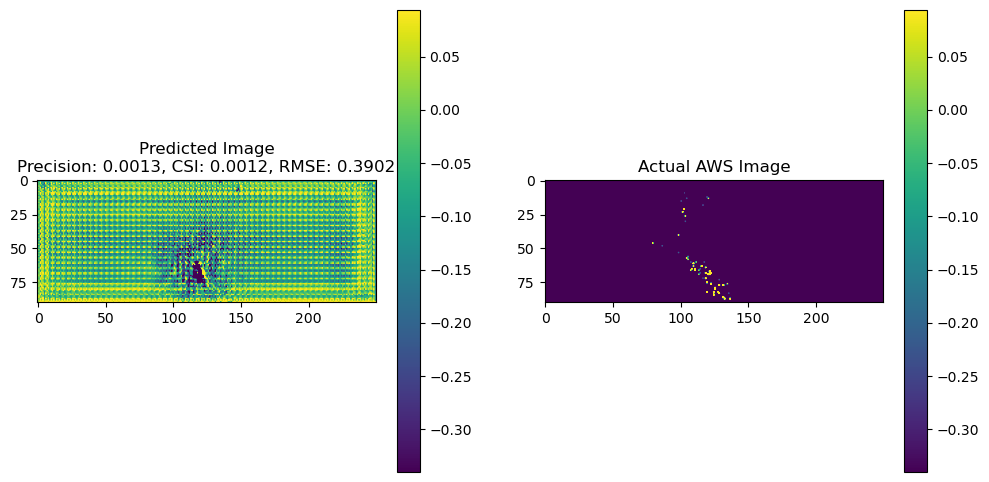

Before transformation X1 contains non-finite values: Min: 0.0, Max: 5.576250076293945, Mean: 0.0038268682546913624, Std: 0.08269345015287399
Before transformation X1 contains non-finite values: Min: 0.0, Max: 5.0, Mean: 0.2584474980831146, Std: 0.6373826265335083
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0019, CSI: 0.0018, RMSE: 0.4500


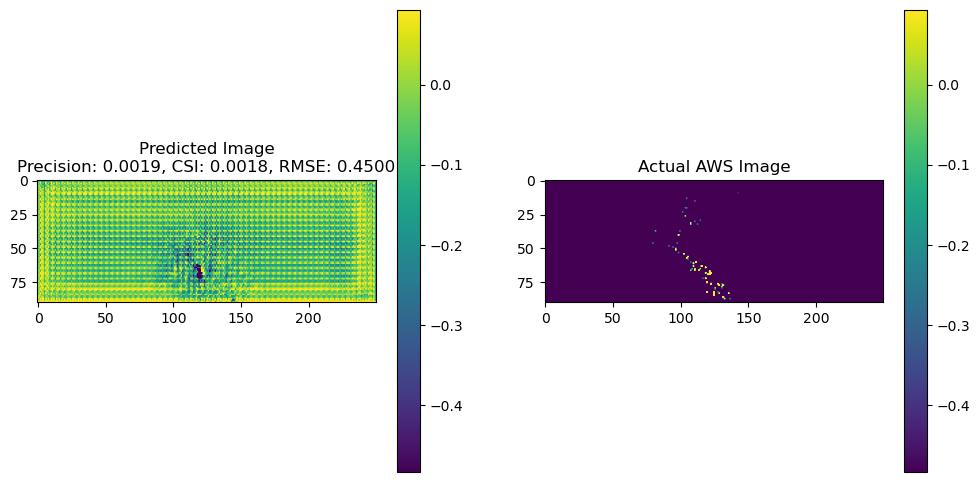

Before transformation X1 contains non-finite values: Min: 0.0, Max: 8.640000343322754, Mean: 0.007619883399456739, Std: 0.14795632660388947
Before transformation X1 contains non-finite values: Min: 0.0, Max: 4.400000095367432, Mean: 0.24172335863113403, Std: 0.513974666595459
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0013, CSI: 0.0012, RMSE: 0.4486


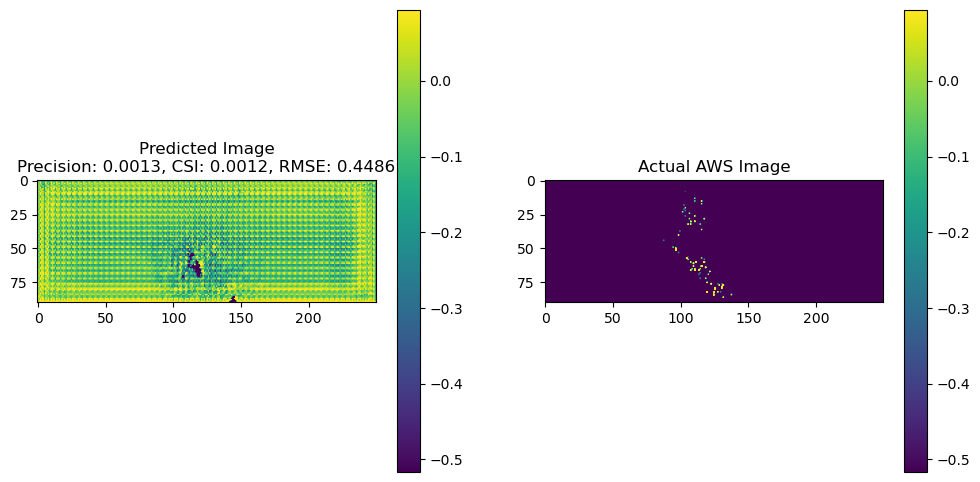

Before transformation X1 contains non-finite values: Min: 0.0, Max: 1.6168749332427979, Mean: 0.00357999699190259, Std: 0.05524251610040665
Before transformation X1 contains non-finite values: Min: 0.0, Max: 3.4000000953674316, Mean: 0.25758621096611023, Std: 0.5089147090911865
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0010, CSI: 0.0009, RMSE: 0.4329


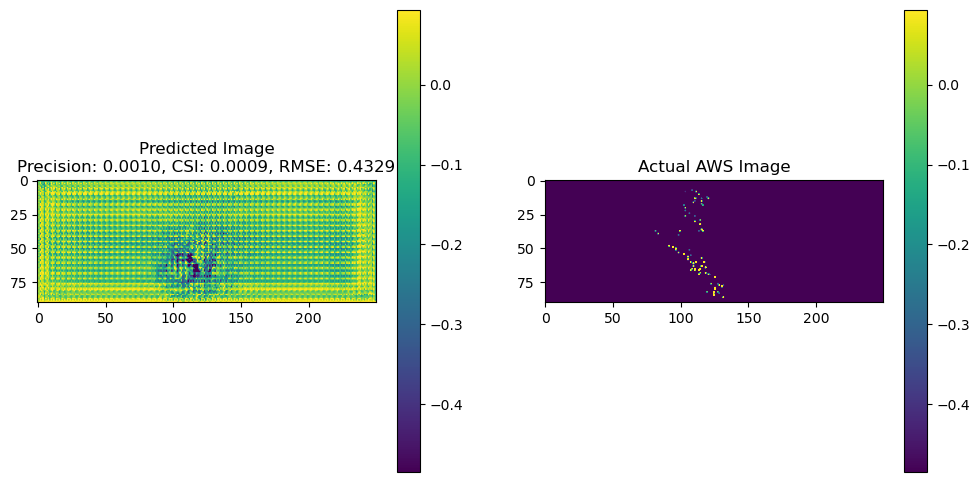

Before transformation X1 contains non-finite values: Min: 0.0, Max: 7.452499866485596, Mean: 0.007498795632272959, Std: 0.15090417861938477
Before transformation X1 contains non-finite values: Min: 0.0, Max: 5.0, Mean: 0.26918673515319824, Std: 0.6901155114173889
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0020, CSI: 0.0020, RMSE: 0.4914


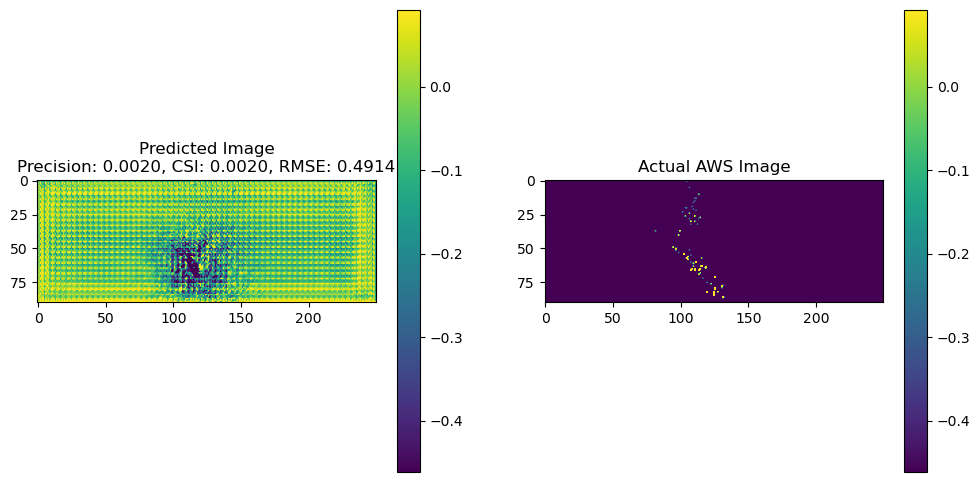

Before transformation X1 contains non-finite values: Min: 0.0, Max: 16.296875, Mean: 0.012375302612781525, Std: 0.26677587628364563
Before transformation X1 contains non-finite values: Min: 0.0, Max: 3.799999952316284, Mean: 0.20103448629379272, Std: 0.5215021371841431
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0010, CSI: 0.0010, RMSE: 0.6161


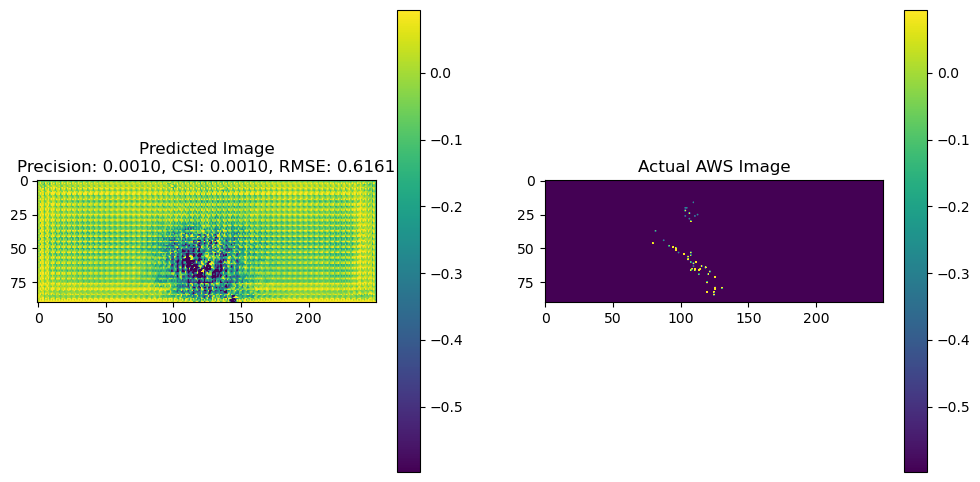

Before transformation X1 contains non-finite values: Min: 0.0, Max: 16.59375, Mean: 0.018095068633556366, Std: 0.3288462162017822
Before transformation X1 contains non-finite values: Min: 0.0, Max: 5.800000190734863, Mean: 0.13240419328212738, Std: 0.42757174372673035
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0010, CSI: 0.0010, RMSE: 0.7005


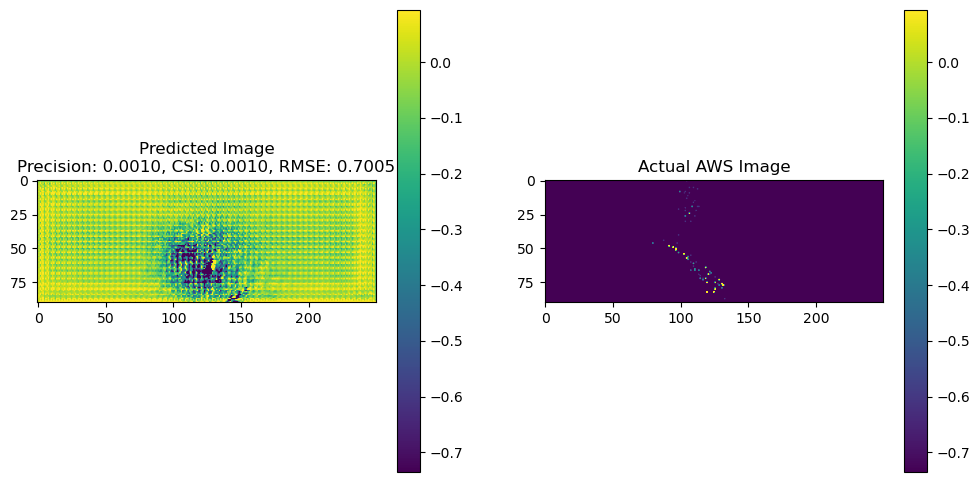

Before transformation X1 contains non-finite values: Min: 0.0, Max: 56.1875, Mean: 0.024131622165441513, Std: 0.6138935089111328
Before transformation X1 contains non-finite values: Min: 0.0, Max: 3.0, Mean: 0.1276816725730896, Std: 0.40702545642852783
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0007, CSI: 0.0007, RMSE: 0.7633


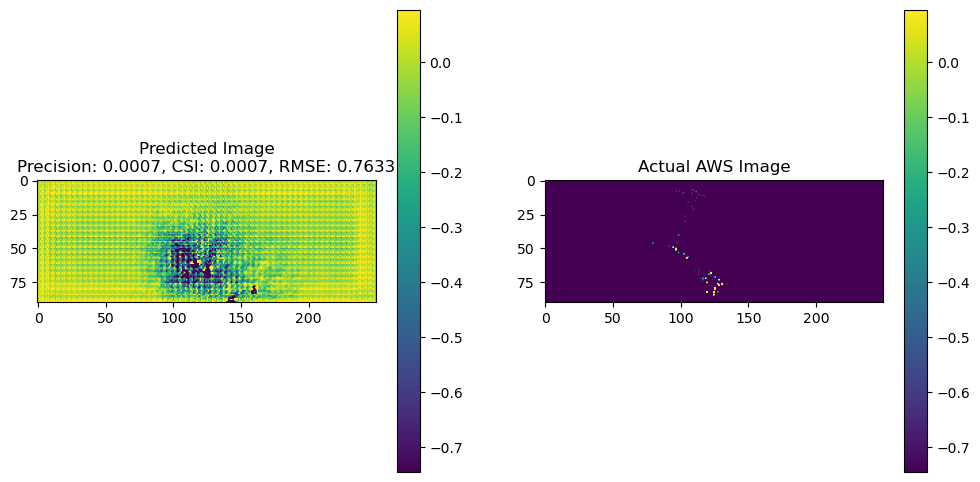

Before transformation X1 contains non-finite values: Min: 0.0, Max: 67.30437469482422, Mean: 0.037629202008247375, Std: 0.9112783670425415
Before transformation X1 contains non-finite values: Min: 0.0, Max: 4.0, Mean: 0.0743902325630188, Std: 0.31035706400871277
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0000, CSI: 0.0000, RMSE: 0.7902


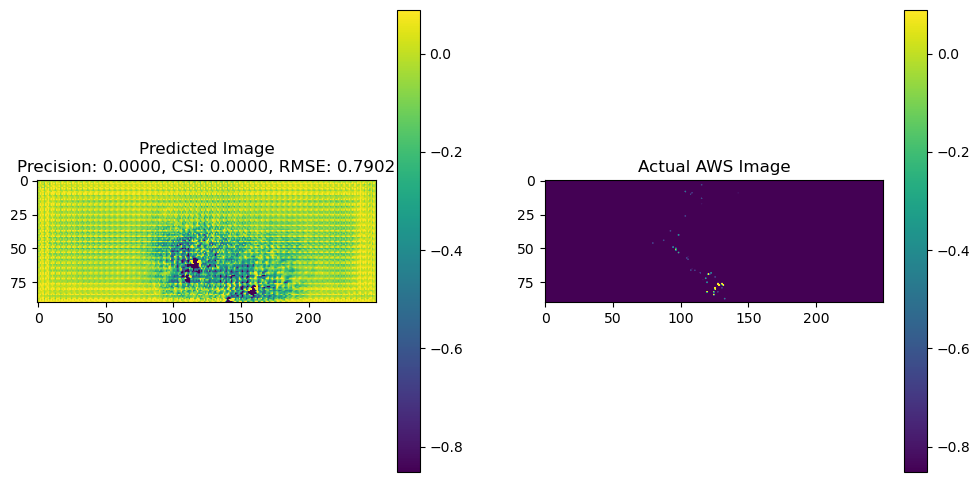

Before transformation X1 contains non-finite values: Min: 0.0, Max: 16.60562515258789, Mean: 0.027731262147426605, Std: 0.3811067044734955
Before transformation X1 contains non-finite values: Min: 0.0, Max: 7.0, Mean: 0.07192982733249664, Std: 0.46315255761146545
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0000, CSI: 0.0000, RMSE: 0.7803


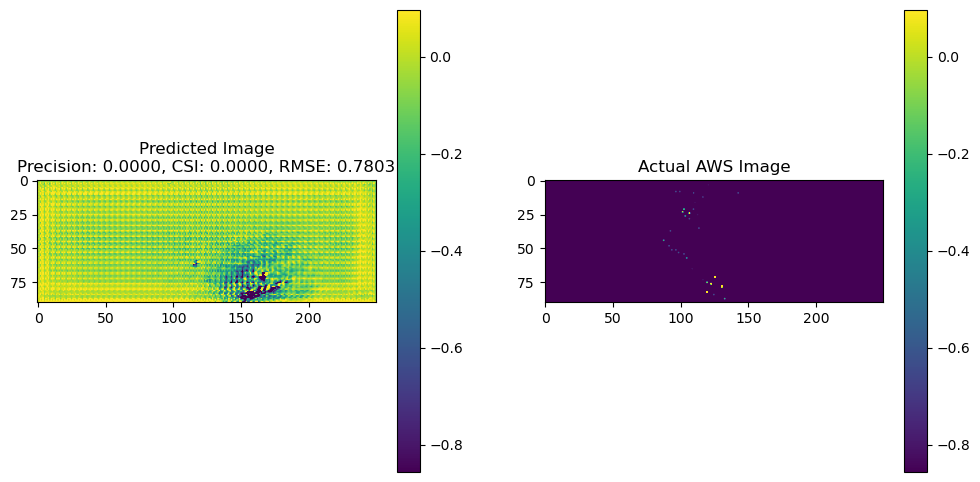

Before transformation X1 contains non-finite values: Min: 0.0, Max: 17.97624969482422, Mean: 0.037565652281045914, Std: 0.494689404964447
Before transformation X1 contains non-finite values: Min: 0.0, Max: 8.800000190734863, Mean: 0.0958762913942337, Std: 0.5671265125274658
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0004, CSI: 0.0004, RMSE: 0.7968


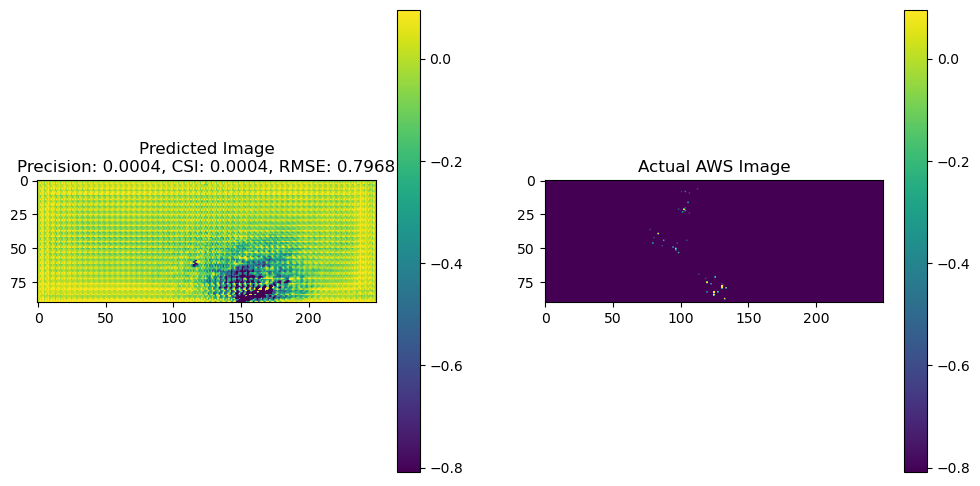

Before transformation X1 contains non-finite values: Min: 0.0, Max: 62.125, Mean: 0.13379018008708954, Std: 1.647783875465393
Before transformation X1 contains non-finite values: Min: 0.0, Max: 2.5999999046325684, Mean: 0.053587958216667175, Std: 0.24552054703235626
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0000, CSI: 0.0000, RMSE: 0.8047


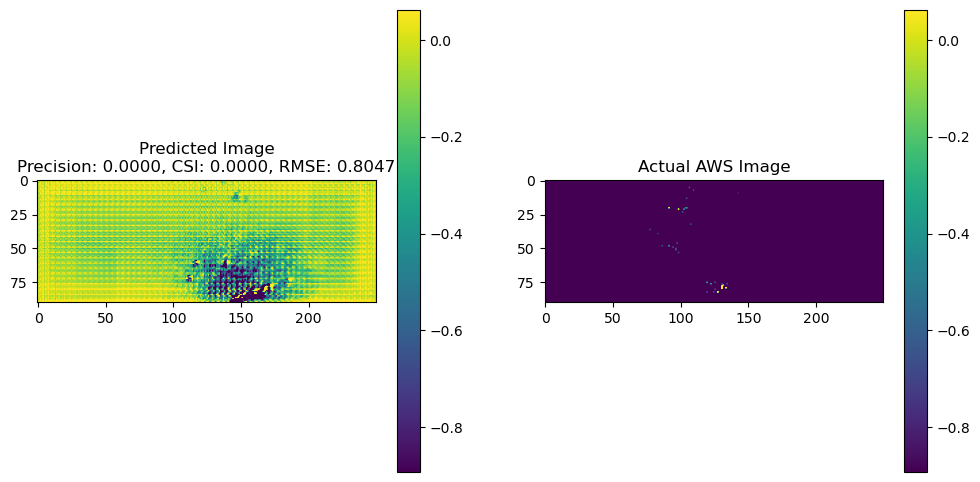

Before transformation X1 contains non-finite values: Min: 0.0, Max: 37.295623779296875, Mean: 0.08439209312200546, Std: 0.9947524666786194
Before transformation X1 contains non-finite values: Min: 0.0, Max: 4.800000190734863, Mean: 0.07195401936769485, Std: 0.40207651257514954
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0005, CSI: 0.0005, RMSE: 0.7794


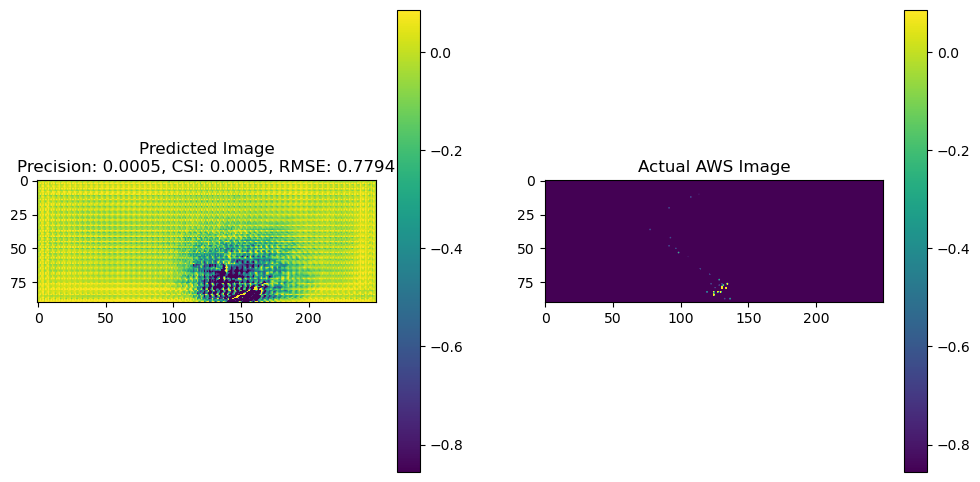

Before transformation X1 contains non-finite values: Min: 0.0, Max: 154.0625, Mean: 0.42193740606307983, Std: 4.612588882446289
Before transformation X1 contains non-finite values: Min: 0.0, Max: 4.199999809265137, Mean: 0.09010416269302368, Std: 0.4405815601348877
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0024, CSI: 0.0023, RMSE: 0.6866


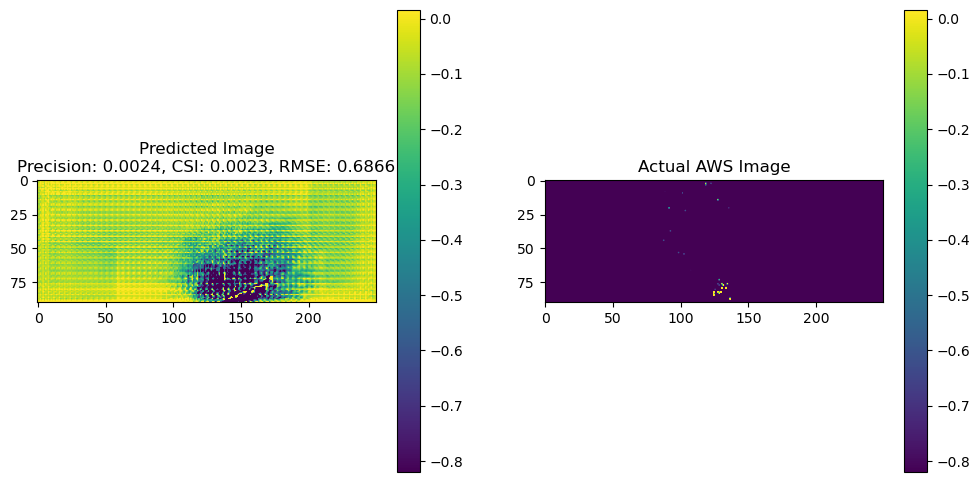

Before transformation X1 contains non-finite values: Min: 0.0, Max: 124.25, Mean: 0.46508654952049255, Std: 4.330748081207275
Before transformation X1 contains non-finite values: Min: 0.0, Max: 6.599999904632568, Mean: 0.15011534094810486, Std: 0.6911396384239197
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0041, CSI: 0.0039, RMSE: 0.6176


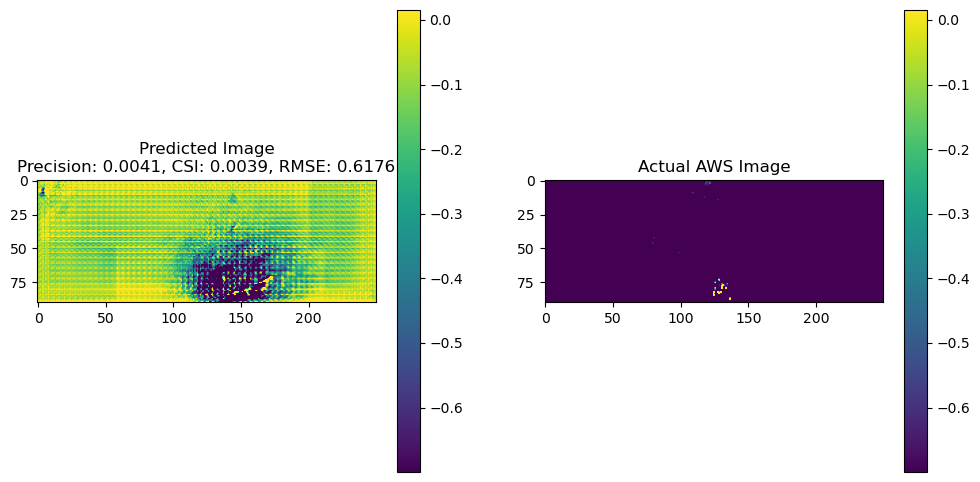

Before transformation X1 contains non-finite values: Min: 0.0, Max: 110.25, Mean: 0.3440902829170227, Std: 3.4558210372924805
Before transformation X1 contains non-finite values: Min: 0.0, Max: 13.800000190734863, Mean: 0.20592334866523743, Std: 1.0794241428375244
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0038, CSI: 0.0036, RMSE: 0.5508


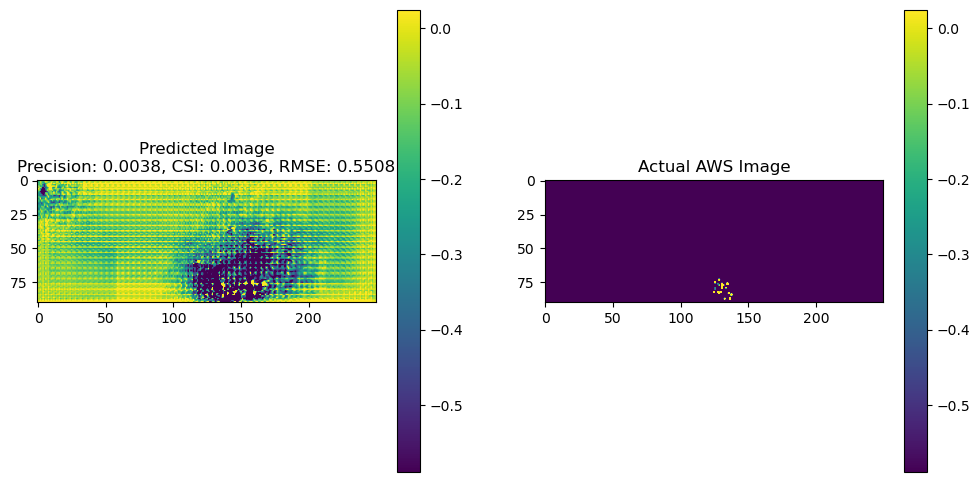

Before transformation X1 contains non-finite values: Min: 0.0, Max: 78.9375, Mean: 0.19054239988327026, Std: 1.9655324220657349
Before transformation X1 contains non-finite values: Min: 0.0, Max: 12.600000381469727, Mean: 0.27785468101501465, Std: 1.2091609239578247
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0028, CSI: 0.0027, RMSE: 0.5889


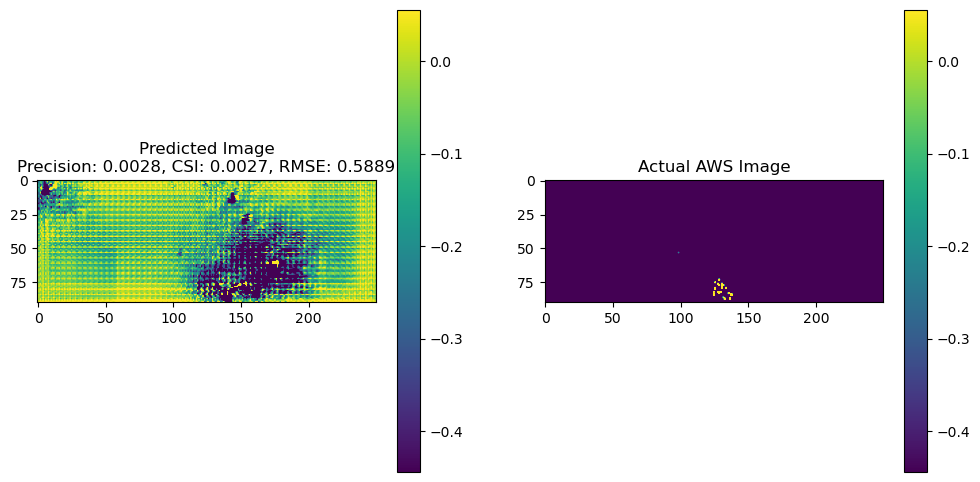

Before transformation X1 contains non-finite values: Min: 0.0, Max: 70.75, Mean: 0.11438489705324173, Std: 1.4341975450515747
Before transformation X1 contains non-finite values: Min: 0.0, Max: 8.0, Mean: 0.14780092239379883, Std: 0.7202985882759094
torch.Size([1, 2, 1, 90, 250])
Precision: 0.0021, CSI: 0.0021, RMSE: 0.6788


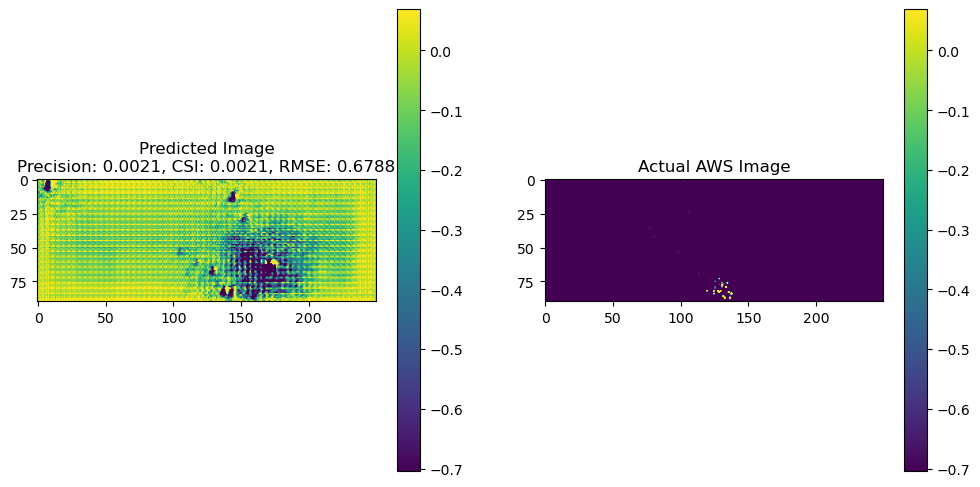

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score

def get_vmin_vmax(image, lower_pct=5, upper_pct=95):
    """ Calculate the vmin and vmax for an image based on percentiles. """
    vmin, vmax = np.percentile(image, [lower_pct, upper_pct])
    return vmin, vmax

def visualize_results(predictions, actuals, precision, csi, rmse):
    plt.figure(figsize=(12, 6))

    if predictions.ndim > 2:
        predictions = predictions[0]
    if actuals.ndim > 2:
        actuals = actuals[0]

    vmin, vmax = get_vmin_vmax(np.concatenate([predictions, actuals]))  # Adjust as needed

    plt.subplot(1, 2, 1)
    # plt.imshow(predictions, cmap='grey', vmin=vmin, vmax=vmax)
    plt.imshow(predictions, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(f"Predicted Image\nPrecision: {precision:.4f}, CSI: {csi:.4f}, RMSE: {rmse:.4f}")
    
    plt.subplot(1, 2, 2)
    # plt.imshow(actuals, cmap='grey', vmin=vmin, vmax=vmax)
    plt.imshow(actuals, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title("Actual AWS Image")
    plt.show()

def get_vmin_vmax(data, lower_pct=5, upper_pct=95):
    vmin = np.percentile(data, lower_pct)
    vmax = np.percentile(data, upper_pct)
    return vmin, vmax


def test_model(test_loader, aws_loader, model, device):
    """ Test the model with test data and corresponding AWS actual data. """
    model.eval()
    with torch.no_grad():
        for test_data, aws_data in zip(test_loader, aws_loader):
            test_inputs = test_data[0].to(device)
            aws_inputs = aws_data[0].to(device)

            # Forward pass to get outputs
            outputs = model(test_inputs)

            # Outputs and aws_inputs need to be processed to match dimensions etc.
            predictions = outputs.squeeze().cpu().numpy()
            actuals = aws_inputs.squeeze().cpu().numpy()
            
            # Compute metrics
            precision, csi, rmse = compute_metrics(predictions, actuals)
            print(f'Precision: {precision:.4f}, CSI: {csi:.4f}, RMSE: {rmse:.4f}')
            
            # Visualize the results
            visualize_results(predictions, actuals, precision, csi, rmse)

test_model(test_loader, AWS_loader, model, device)
